In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport mutation_features, methylation_pred, compute_comethylation
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, somatic_mut_clock, mutation_features, methylation_pred

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
import colorcet as cc
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV

%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

In [3]:
out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output"
dependency_f_dir = "/cellar/users/zkoch/methylation_and_mutation/dependency_files"
data_dir = "/cellar/users/zkoch/methylation_and_mutation/data"
corr_dir = '/cellar/users/zkoch/methylation_and_mutation/dependency_files/chr_dset_corrs'
#methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/processed_methylation'
methylation_dir =  '/cellar/users/zkoch/methylation_and_mutation/data/dropped3SD_qnormed_methylation'

# TCGA

### Get data

In [4]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, dataset_names_list = get_data.main(
    illum_cpg_locs_fn = os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"),
    out_dir = out_dir,
    methyl_dir = methylation_dir,
    mut_fn = os.path.join(data_dir, "PANCAN_mut.tsv.gz"),
    meta_fn = os.path.join(data_dir, "PANCAN_meta.tsv"))
# read in other already computed files
mut_in_measured_cpg_w_methyl_age_df = pd.read_parquet(os.path.join(dependency_f_dir, "mut_in_measured_cpg_w_methyl_age_df_5year.parquet"))
all_mut_w_age_df, all_methyl_age_df_t = utils.add_ages_to_mut_and_methyl(all_mut_df, all_meta_df, all_methyl_df_t)

Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [31]:
illumina_cpg_locs_df = pd.read_csv(os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"))

/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## somatic-meQTLs from DB meQTLs

In [158]:
godmc_meqtls = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/data/meQTL/goDMC_meQTL/goDMC_meQTLs_for_mutClock.parquet')

In [258]:
mut_scan = compute_comethylation.mutationScan(
    all_mut_w_age_df, illumina_cpg_locs_df, 
    all_methyl_age_df_t, corr_dir = corr_dir,
    age_bin_size = 5, max_dist = 1000,
    num_correl_sites = 100, num_background_events = 3,
    matched_sample_num = 20
    )

In [260]:
comparison_sites_df, all_metrics_df = mut_scan.look_for_disturbances(
    start_num_mut_to_process = 0,
    end_num_mut_to_process = 3,
    linkage_method='db', 
    out_dir = out_dir, 
    corr_direction = 'pos',
    meqtl_db_df = godmc_meqtls,
    #comparison_sites_df = comparison_sites_df
    )

Getting comparison sites from meQTL database...
Number of mutation events with that are meQTL : 148


Getting matched samples: 100%|██████████| 148/148 [00:09<00:00, 16.12it/s]

Number mutation events being processed after filtering for matched sample number of 20: 99
Number of mutation events being processed based on start_num_mut_to_process and end_num_mut_to_process: 3
Getting background sites...


got unique meqtl snps


/cellar/users/zkoch/methylation_and_mutation/source_files/compute_comethylation.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  background_comp_sites.rename(columns={'cpg': 'comparison_sites'}, inplace=True)


finished 0.0% of background events
finished 33.333333333333336% of background events
finished 66.66666666666667% of background events
12 mutation events total (background and foreground) to be processed
Wrote comparison sites df to /cellar/users/zkoch/methylation_and_mutation/output_dirs/031423_comethyl_output/comparison_sites_0-3Muts_db-linked_qnorm3SD_3background


Calculating effect of mutation on comparison sites: 100%|██████████| 12/12 [00:03<00:00,  3.49it/s]

Done getting effect of mutation on each site
got all metrics


writing results to /cellar/users/zkoch/methylation_and_mutation/output_dirs/031423_comethyl_output/all_metrics_0-3Muts_db-linked_qnorm3SD_3background


## Distance-based testing

In [6]:
mut_scan = compute_comethylation.mutationScan(
    all_mut_w_age_df, illumina_cpg_locs_df, 
    all_methyl_age_df_t, corr_dir = corr_dir,
    age_bin_size = 10, max_dist = 500,
    num_correl_sites = 10, num_background_events = 3,
    matched_sample_num = 20
    )

In [ ]:
comparison_sites_df, all_metrics_df = mut_scan.look_for_disturbances(
    start_num_mut_to_process = 0,
    end_num_mut_to_process = 3,
    linkage_method='dist', 
    out_dir = out_dir, 
    corr_direction = 'pos'
    #comparison_sites_df = comparison_sites_df
    )

## Corr-based testing

In [9]:
mut_scan = compute_comethylation.mutationScan(
    all_mut_w_age_df, illumina_cpg_locs_df, 
    all_methyl_age_df_t, corr_dir = corr_dir,
    age_bin_size = 10, max_dist = 500,
    num_correl_sites = 10, num_background_events = 3,
    matched_sample_num = 20
    )

In [15]:
comparison_sites_df, all_metrics_df = mut_scan.look_for_disturbances(
    start_num_mut_to_process = 0,
    end_num_mut_to_process = 3,
    linkage_method='correl', 
    out_dir = out_dir, 
    corr_direction = 'pos'
    #comparison_sites_df = comparison_sites_df
    )

Number mutation events being processed: 9641


Getting mut site delta MF: 100%|██████████| 94/94 [00:00<00:00, 2859.17it/s]

Number mutation events being processed after filtering for matched sample number: 3



Getting comparison sites: 100%|██████████| 3/3 [00:10<00:00,  3.53s/it]

Getting background sites...


12 mutation events total (background and foreground) to be processed
Wrote comparison sites df to /cellar/users/zkoch/methylation_and_mutation/output_dirs/031423_comethyl_output/comparison_sites_0-3Muts_correl-linked_qnorm3SD_3background


Calculating effect of mutation on comparison sites: 100%|██████████| 12/12 [00:13<00:00,  1.12s/it]

Done getting effect of mutation on each site
got all metrics


writing results to /cellar/users/zkoch/methylation_and_mutation/output_dirs/031423_comethyl_output/all_metrics_0-3Muts_correl-linked_qnorm3SD_3background


In [16]:
all_metrics_df

,sample,measured_site,delta_mf_median,mutated_sample,zscore_abs_delta_mf_median,delta_mf_mean,zscore_abs_delta_mf_mean,delta_mf_median_pval2,abs_delta_mf_median_pval,abs_delta_mf_mean_pval,zscore_median_pval2,zscore_mean_pval,mut_loc,mut_event,is_background,index_event,measured_site_dist
0,TCGA-05-4390,cg08668997,-0.002594,False,-0.046133,-0.002025,-0.211161,0.028611,0.518572,0.715435,0.883586,0.831984,17:7579312,TCGA-05-4415_17:7579312,False,self,0
1,TCGA-05-4390,cg01359015,-0.000518,False,-1.299208,0.001218,-1.259347,0.028611,0.518572,0.715435,0.883586,0.831984,17:7579312,TCGA-05-4415_17:7579312,False,self,1
2,TCGA-05-4390,cg18493449,-0.000350,False,-1.000496,0.001359,-0.901660,0.028611,0.518572,0.715435,0.883586,0.831984,17:7579312,TCGA-05-4415_17:7579312,False,self,2
3,TCGA-05-4390,cg06012656,0.011103,False,0.253115,0.011626,0.316670,0.028611,0.518572,0.715435,0.883586,0.831984,17:7579312,TCGA-05-4415_17:7579312,False,self,3
4,TCGA-05-4390,cg08008636,0.002762,False,-0.301879,0.004546,-0.135677,0.028611,0.518572,0.715435,0.883586,0.831984,17:7579312,TCGA-05-4415_17:7579312,False,self,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,TCGA-05-5423,cg18202577,-0.001185,True,-0.109141,-0.004167,-0.053215,0.000996,0.017306,0.242716,0.017244,0.132595,15:65809620,TCGA-05-5423_15:65809620,True,TCGA-05-5423_2:27805334,5
1636,TCGA-05-5423,cg15202245,0.006205,True,0.183489,0.004729,0.054687,0.000996,0.017306,0.242716,0.017244,0.132595,15:65809620,TCGA-05-5423_15:65809620,True,TCGA-05-5423_2:27805334,6
1637,TCGA-05-5423,cg26277456,0.006908,True,0.072134,0.004240,-0.080829,0.000996,0.017306,0.242716,0.017244,0.132595,15:65809620,TCGA-05-5423_15:65809620,True,TCGA-05-5423_2:27805334,7
1638,TCGA-05-5423,cg08455700,0.010250,True,1.359804,0.009119,1.155826,0.000996,0.017306,0.242716,0.017244,0.132595,15:65809620,TCGA-05-5423_15:65809620,True,TCGA-05-5423_2:27805334,8


## Read in results

In [37]:
# read in comp sites from dask paruet
"""
# DATABASE
comparison_sites_dd = dd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/031423_comethyl_output/comparison_sites_0-1000Muts_db-linked_qnorm3SD_100background")
comparison_sites_df = comparison_sites_dd.compute()
all_metrics_dd = dd.read_parquet( "/cellar/users/zkoch/methylation_and_mutation/output_dirs/031423_comethyl_output/all_metrics_0-1000Muts_db-linked_qnorm3SD_100background")
all_metrics_df = all_metrics_dd.compute()"""

# distance
paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/distance_based_500Max/all_metrics*")
c_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/distance_based_500Max/comparison_sites*")

dist_all_metrics_dfs = []
for path in paths:
    # read in metrics sites from dask paruet
    one_metrics_dd = dd.read_parquet(path)
    one_metrics_df = one_metrics_dd.compute()
    dist_all_metrics_dfs.append(one_metrics_df)
dist_all_metrics_df = pd.concat(dist_all_metrics_dfs)
dist_all_metrics_df.reset_index(inplace=True, drop=True)

"""
dist_all_comparison_site_dfs = []
for path in c_paths:
    # read in metrics sites from dask paruet
    one_comp_dd = dd.read_parquet(path)
    one_comp_df = one_comp_dd.compute()
    dist_all_comparison_site_dfs.append(one_comp_df)
dist_all_comparison_site_df = pd.concat(dist_all_comparison_site_dfs)
dist_all_comparison_site_df.reset_index(inplace=True, drop=True)"""

# correlation
paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/correl_based_10Top/all_metrics*")
c_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/correl_based_10Top/comparison_sites*")

"""all_metrics_dfs = []
for path in paths:
    # read in metrics sites from dask paruet
    one_metrics_dd = dd.read_parquet(path)
    one_metrics_df = one_metrics_dd.compute()
    all_metrics_dfs.append(one_metrics_df)
all_metrics_df = pd.concat(all_metrics_dfs)
all_metrics_df.reset_index(inplace=True, drop=True)


all_comparison_site_dfs = []
for path in c_paths:
    # read in metrics sites from dask paruet
    one_comp_dd = dd.read_parquet(path)
    one_comp_df = one_comp_dd.compute()
    all_comparison_site_dfs.append(one_comp_df)
all_comparison_site_df = pd.concat(all_comparison_site_dfs)
all_comparison_site_df.reset_index(inplace=True, drop=True)

# literature meQTLS
lit_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/*db/all_metrics*")
lit_c_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/*db/comparison_sites*")

lit_all_metrics_dfs = []
for path in lit_paths:
    # read in metrics sites from dask paruet
    one_metrics_dd = dd.read_parquet(path)
    one_metrics_df = one_metrics_dd.compute()
    lit_all_metrics_dfs.append(one_metrics_df)
lit_all_metrics_df = pd.concat(lit_all_metrics_dfs)
lit_all_metrics_df.reset_index(inplace=True, drop=True)


lit_all_comparison_site_dfs = []
for path in lit_c_paths:
    # read in metrics sites from dask paruet
    one_comp_dd = dd.read_parquet(path)
    one_comp_df = one_comp_dd.compute()
    lit_all_comparison_site_dfs.append(one_comp_df)
lit_all_comparison_site_df = pd.concat(lit_all_comparison_site_dfs)
lit_all_comparison_site_df.reset_index(inplace=True, drop=True)"""

'all_metrics_dfs = []\nfor path in paths:\n    # read in metrics sites from dask paruet\n    one_metrics_dd = dd.read_parquet(path)\n    one_metrics_df = one_metrics_dd.compute()\n    all_metrics_dfs.append(one_metrics_df)\nall_metrics_df = pd.concat(all_metrics_dfs)\nall_metrics_df.reset_index(inplace=True, drop=True)\n\n\nall_comparison_site_dfs = []\nfor path in c_paths:\n    # read in metrics sites from dask paruet\n    one_comp_dd = dd.read_parquet(path)\n    one_comp_df = one_comp_dd.compute()\n    all_comparison_site_dfs.append(one_comp_df)\nall_comparison_site_df = pd.concat(all_comparison_site_dfs)\nall_comparison_site_df.reset_index(inplace=True, drop=True)\n\n# literature meQTLS\nlit_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/*db/all_metrics*")\nlit_c_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/*db/comparison_sites*")\n\nlit_all_metrics_dfs = []\nfor path in lit_pat

In [164]:
# import mwu
from scipy.stats import mannwhitneyu, ttest_ind
# import stats.f_oneway
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
sns.set_theme(style='white', font_scale=1.3)

### Distance

##### Comparing FG mut, FG matched, BG mut, BG matched

In [61]:
# map zscore_abs_delta_mf_mean to corresponding pval using cumlative distribution
from scipy.stats import norm
dist_all_metrics_df['zscore_abs_delta_mf_mean_pval'] = 1 - norm.cdf(dist_all_metrics_df['zscore_abs_delta_mf_mean'])
dist_all_metrics_df['zscore_abs_delta_mf_mean_pval_sig'] = dist_all_metrics_df['zscore_abs_delta_mf_mean_pval'] < 0.05

In [6]:
# get the mean deltaMf across all CpGs for each sample
dist_all_metrics_df['abs_delta_mf_median'] = dist_all_metrics_df['delta_mf_median'].abs()
dist_all_metrics_df['abs_zscore_abs_delta_mf_median'] = dist_all_metrics_df['zscore_abs_delta_mf_median'].abs()

grouped_dist_all_metrics_df = dist_all_metrics_df.groupby(['mut_event', 'sample'])
mean_by_sample = grouped_dist_all_metrics_df[['delta_mf_median', 'zscore_abs_delta_mf_median', 'abs_delta_mf_median', 'abs_zscore_abs_delta_mf_median']].mean()
mean_by_sample.columns = ['mean_dmf', 'mean_zdmf', 'mean_abs_dmf', 'mean_abs_zdmf']
median_by_sample = grouped_dist_all_metrics_df[['delta_mf_median', 'zscore_abs_delta_mf_median', 'abs_delta_mf_median', 'abs_zscore_abs_delta_mf_median']].median()
median_by_sample.columns = ['median_dmf', 'median_zdmf', 'median_abs_dmf', 'median_abs_zdmf']

# merge these dfs 
dist_mean_metrics_df = mean_by_sample.merge(median_by_sample, left_index=True, right_index=True)

mut_event_to_background_map = dist_all_metrics_df.drop_duplicates(subset=['mut_event', 'sample'])
mut_event_to_background_map.set_index(['mut_event', 'sample'], inplace=True)
dist_all_mean_metrics_df = dist_mean_metrics_df.merge(mut_event_to_background_map[['is_background', 'index_event', 'mutated_sample']], left_index=True, right_index=True)

In [90]:

tests_dict = {}
# for each metric, print the t-test and wilcoxon test p-values for FG mut vs FG matched, and BG mut vs BG matched
for metric in ['zscore_abs_delta_mf_mean', 'delta_mf_median']:#
    # is the mutated sample, background is false
    fg_mut = all_metrics_df.loc[(all_metrics_df['is_background'] == False) & (all_metrics_df['mutated_sample'] == True), metric]
    fg_matched = all_metrics_df.loc[(all_metrics_df['is_background'] == False) & (all_metrics_df['mutated_sample'] == False), metric]
    # is the mutated sample, background is true
    bg_mut = all_metrics_df.loc[(all_metrics_df['is_background'] == True) & (all_metrics_df['mutated_sample'] == True), metric]
    bg_matched = all_metrics_df.loc[(all_metrics_df['is_background'] == True) & (all_metrics_df['mutated_sample'] == False), metric]
    
    # FG mut vs FG matched
    fg_ttest = ttest_ind(fg_mut, fg_matched, alternative = 'two-sided', equal_var=False).pvalue
    fg_mwu = mannwhitneyu(fg_mut, fg_matched, alternative = 'two-sided').pvalue
    fg_effect_size = (fg_mut.mean() - fg_matched.mean())
    # BG mut vs BG matched
    bg_ttest = ttest_ind(bg_mut, bg_matched, alternative = 'two-sided', equal_var=False).pvalue
    bg_mwu = mannwhitneyu(bg_mut, bg_matched, alternative = 'two-sided').pvalue
    bg_effect_size = (bg_mut.mean() - bg_matched.mean())
    
    # anova between all 4 groups
    anova = stats.f_oneway(fg_mut, fg_matched, bg_mut, bg_matched)
    # post-hoc tukey test
    groups_df = pd.concat([fg_mut, fg_matched, bg_mut, bg_matched]).reset_index()
    groups_df['group'] = ['fg_mut'] * len(fg_mut) + ['fg_matched'] * len(fg_matched) + ['bg_mut'] * len(bg_mut) + ['bg_matched'] * len(bg_matched)
    tukey = pairwise_tukeyhsd(groups_df[metric], groups_df['group'], alpha=0.05)

    tests_dict[metric] = {'fg_ttest': fg_ttest, 'fg_mwu': fg_mwu, 'fg_effect_size': fg_effect_size, 'bg_ttest': bg_ttest, 'bg_mwu': bg_mwu, 'bg_effect_size': bg_effect_size, 'anova': anova, 'tukey': tukey}
tests_df = pd.DataFrame(tests_dict).T

In [5]:
dist_all_mean_metrics_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/distance_based_500Max/dist_all_mean_metrics_df.parquet')

In [ ]:
# test for a difference between mean metric value across each set of comparison sites

dist_mean_tests_dict_twoPlus = {}
# for each metric, print the t-test and wilcoxon test p-values for FG mut vs FG matched, and BG mut vs BG matched
for metric in ['mean_dmf','mean_abs_dmf', 'mean_abs_zdmf', 'median_abs_dmf', 'median_abs_zdmf', 'mean_dmf', 'mean_zdmf','median_dmf','median_zdmf']:
    fg_mut = dist_all_mean_metrics_df.loc[
        (dist_all_mean_metrics_df['is_background'] == False) 
        & (dist_all_mean_metrics_df['mutated_sample'] == True)
        & (dist_all_mean_metrics_df.num_comparison_sites >= 2), metric]
    fg_matched = dist_all_mean_metrics_df.loc[
        (dist_all_mean_metrics_df['is_background'] == False) 
        & (dist_all_mean_metrics_df['mutated_sample'] == False)
        & (dist_all_mean_metrics_df.num_comparison_sites >= 2), metric]
    # is the mutated sample, background is true
    bg_mut = dist_all_mean_metrics_df.loc[
        (dist_all_mean_metrics_df['is_background'] == True)
        & (dist_all_mean_metrics_df['mutated_sample'] == True)
        & (dist_all_mean_metrics_df.num_comparison_sites >= 2), metric]
    bg_matched = dist_all_mean_metrics_df.loc[
        (dist_all_mean_metrics_df['is_background'] == True) 
        & (dist_all_mean_metrics_df['mutated_sample'] == False)
        & (dist_all_mean_metrics_df.num_comparison_sites >= 2), metric]
    
    # FG mut vs FG matched
    fg_ttest = ttest_ind(fg_mut, fg_matched, alternative = 'greater', equal_var=False).pvalue
    fg_mwu = mannwhitneyu(fg_mut, fg_matched, alternative = 'greater').pvalue
    fg_effect_size = (fg_mut.mean() - fg_matched.mean())
    # BG mut vs BG matched
    bg_ttest = ttest_ind(bg_mut, bg_matched, alternative = 'greater', equal_var=False).pvalue
    bg_mwu = mannwhitneyu(bg_mut, bg_matched, alternative = 'greater').pvalue
    bg_effect_size = (bg_mut.mean() - bg_matched.mean())
    
    # anova between all 4 groups
    anova = stats.f_oneway(fg_mut, fg_matched, bg_mut, bg_matched)
    # post-hoc tukey test
    groups_df = pd.concat([fg_mut, fg_matched, bg_mut, bg_matched]).reset_index()
    groups_df['group'] = ['fg_mut'] * len(fg_mut) + ['fg_matched'] * len(fg_matched) + ['bg_mut'] * len(bg_mut) + ['bg_matched'] * len(bg_matched)
    tukey = pairwise_tukeyhsd(groups_df[metric], groups_df['group'], alpha=0.05)

    dist_mean_tests_dict_twoPlus[metric] = {'fg_ttest': fg_ttest, 'fg_mwu': fg_mwu, 'fg_effect_size': fg_effect_size, 'bg_ttest': bg_ttest, 'bg_mwu': bg_mwu, 'bg_effect_size': bg_effect_size, 'anova': anova, 'tukey': tukey}
    print("done with {}".format(metric), flush=True)
dist_mean_tests_twoPlus_df = pd.DataFrame(dist_mean_tests_dict_twoPlus).T
dist_mean_tests_twoPlus_df['effect_ratio'] = dist_mean_tests_twoPlus_df['fg_effect_size'] / dist_mean_tests_twoPlus_df['bg_effect_size']

done with mean_zdmf


In [152]:
# test for a difference between mean metric value across each set of comparison sites

dist_mean_tests_dict = {}
# for each metric, print the t-test and wilcoxon test p-values for FG mut vs FG matched, and BG mut vs BG matched
for metric in ['mean_dmf']: #, , 'mean_zdmf','median_dmf','median_zdmf' 'mean_abs_dmf', 'mean_abs_zdmf', 'median_abs_dmf', 'median_abs_zdmf', 'mean_dmf', 
    fg_mut = dist_all_mean_metrics_df.loc[
        (dist_all_mean_metrics_df['is_background'] == False) 
        & (dist_all_mean_metrics_df['mutated_sample'] == True)
        & (dist_all_mean_metrics_df.num_comparison_sites >= 2)
        & (dist_all_mean_metrics_df.Relation_to_UCSC_CpG_Island != 'Island'), metric]
    fg_matched = dist_all_mean_metrics_df.loc[
        (dist_all_mean_metrics_df['is_background'] == False) 
        & (dist_all_mean_metrics_df['mutated_sample'] == False)
        & (dist_all_mean_metrics_df.num_comparison_sites >= 2)
        & (dist_all_mean_metrics_df.Relation_to_UCSC_CpG_Island != 'Island'), metric]
    # is the mutated sample, background is true
    bg_mut = dist_all_mean_metrics_df.loc[
        (dist_all_mean_metrics_df['is_background'] == True)
        & (dist_all_mean_metrics_df['mutated_sample'] == True)
        & (dist_all_mean_metrics_df.num_comparison_sites >= 2)
        & (dist_all_mean_metrics_df.Relation_to_UCSC_CpG_Island != 'Island'), metric]
    bg_matched = dist_all_mean_metrics_df.loc[
        (dist_all_mean_metrics_df['is_background'] == True) 
        & (dist_all_mean_metrics_df['mutated_sample'] == False)
        & (dist_all_mean_metrics_df.num_comparison_sites >= 2)
        & (dist_all_mean_metrics_df.Relation_to_UCSC_CpG_Island != 'Island'), metric]
    
    # FG mut vs FG matched
    fg_ttest = ttest_ind(fg_mut, fg_matched, alternative = 'greater', equal_var=False).pvalue
    fg_mwu = mannwhitneyu(fg_mut, fg_matched, alternative = 'greater').pvalue
    fg_effect_size = (fg_mut.mean() - fg_matched.mean())
    # BG mut vs BG matched
    bg_ttest = ttest_ind(bg_mut, bg_matched, alternative = 'greater', equal_var=False).pvalue
    bg_mwu = mannwhitneyu(bg_mut, bg_matched, alternative = 'greater').pvalue
    bg_effect_size = (bg_mut.mean() - bg_matched.mean())
    
    # anova between all 4 groups
    anova = stats.f_oneway(fg_mut, fg_matched, bg_mut, bg_matched)
    # post-hoc tukey test
    groups_df = pd.concat([fg_mut, fg_matched, bg_mut, bg_matched]).reset_index()
    groups_df['group'] = ['fg_mut'] * len(fg_mut) + ['fg_matched'] * len(fg_matched) + ['bg_mut'] * len(bg_mut) + ['bg_matched'] * len(bg_matched)
    tukey = pairwise_tukeyhsd(groups_df[metric], groups_df['group'], alpha=0.05)

    dist_mean_tests_dict[metric] = {'fg_ttest': fg_ttest, 'fg_mwu': fg_mwu, 'fg_effect_size': fg_effect_size, 'bg_ttest': bg_ttest, 'bg_mwu': bg_mwu, 'bg_effect_size': bg_effect_size, 'anova': anova, 'tukey': tukey}
    print("done with {}".format(metric), flush=True)
dist_mean_tests_df = pd.DataFrame(dist_mean_tests_dict).T
dist_mean_tests_df['effect_ratio'] = dist_mean_tests_df['fg_effect_size'] / dist_mean_tests_df['bg_effect_size']

done with mean_dmf


In [ ]:
dist_mean_tests_twoPlus_df.to_pickle('/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/distance_based_500Max/dist_mean_tests_twoPlus_df.pkl')
#dist_mean_tests_df.to_pickle('/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/distance_based_500Max/dist_mean_tests_df.pkl')

In [127]:
dist_all_comparison_site_df['one_comp_site'] = dist_all_comparison_site_df['comparison_sites'].apply(lambda x: x[0])
dist_all_comparison_site_df_w_illum = dist_all_comparison_site_df.merge(illumina_cpg_locs_df[['IlmnID', 'Relation_to_UCSC_CpG_Island' ]], left_on = 'one_comp_site', right_on = 'IlmnID', how = 'left')

In [133]:
dist_all_comparison_site_df['num_comparison_sites'] = dist_all_comparison_site_df['comparison_sites'].apply(lambda x: len(x))
dist_all_mean_metrics_df = dist_all_mean_metrics_df.merge(dist_all_comparison_site_df_w_illum[['mut_event','num_comparison_sites', 'DNA_VAF','Relation_to_UCSC_CpG_Island' ]], on='mut_event', how='left')

In [137]:
dist_all_mean_metrics_df['Relation_to_UCSC_CpG_Island'].value_counts()

Island     57379731
N_Shore     6847722
S_Shore     1015406
S_Shelf       22613
N_Shelf       22509
Name: Relation_to_UCSC_CpG_Island, dtype: int64

In [30]:
pearsonr(dist_all_mean_metrics_df.loc[dist_all_mean_metrics_df.is_background == False, 'num_comparison_sites'], dist_all_mean_metrics_df.loc[dist_all_mean_metrics_df.is_background == False, 'mean_dmf'])

(0.037878493757374, 6.543943548727038e-190)

Text(0.5, 0, 'Absolute methylation change (Z-score)')

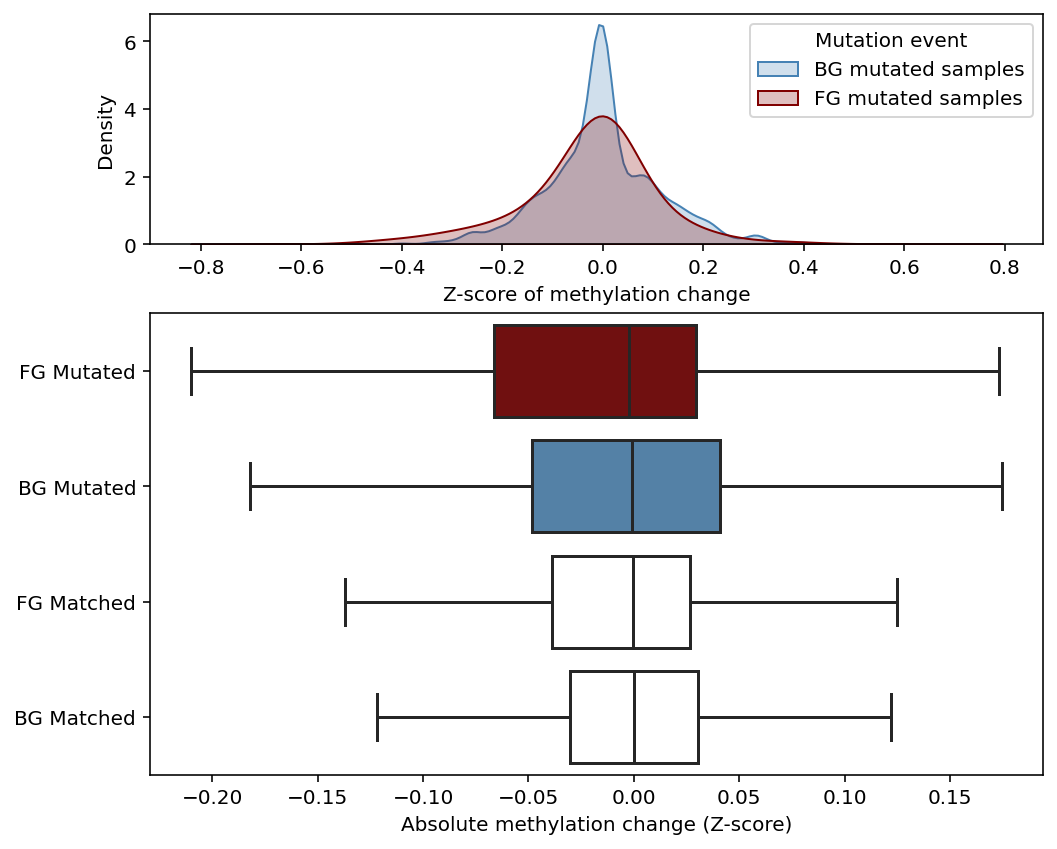

In [147]:

# make second axes taller
fig, axes = plt.subplots(2,1, figsize=(8, 7), sharex=False, gridspec_kw={'height_ratios': [1, 2]})
metric = 'mean_dmf'
mut = dist_all_mean_metrics_df.loc[
    (dist_all_mean_metrics_df.mutated_sample == True)
    & (dist_all_mean_metrics_df.num_comparison_sites >= 2)
    & (dist_all_mean_metrics_df.Relation_to_UCSC_CpG_Island != 'Island')
    ]
mut = mut.rename(columns={'is_background': 'Mutation event'})#.replace({'Mutation event': {True: 'BG mutated samples', False: 'FG mutated samples'}})
# make FG mutated samples in front
sns.kdeplot(data=mut, x=metric, hue='Mutation event', common_norm=False, palette=[ 'maroon', 'steelblue'], fill=True, ax = axes[0], common_grid=True, bw_adjust=2)
#sns.histplot(data=mut, x=metric, hue='Mutation event', common_norm=False, palette=['maroon', 'steelblue'], fill=True, ax = axes[0], stat='probability', bins=50, log_scale=[False, False], common_bins=True)
# set xlim
#axes[0].set_xlim(-2, 4)
# write delta in greek sybol
axes[0].set_xlabel('Z-score of methylation change')
# change legend labels
axes[0].legend(['BG mutated samples', 'FG mutated samples'], loc='upper right', title='Mutation event')


# plot boxplots of mean_zdmf for each of the 4 groups: FG mutated, BG mutated, FG matched, BG matched
to_plot = dist_all_mean_metrics_df.loc[
    dist_all_mean_metrics_df.num_comparison_sites >= 2
    & (dist_all_mean_metrics_df.Relation_to_UCSC_CpG_Island != 'Island')
    ]
to_plot = to_plot[[metric, 'is_background', 'mutated_sample' ]].rename(columns={'is_background': 'FG/BG'}).replace({'FG/BG': {True: 'BG', False: 'FG'}})
to_plot = to_plot.rename(columns={'mutated_sample': 'Sample'}).replace({'Sample': {True: 'Mutated', False: 'Matched'}})
to_plot['combined'] = to_plot['FG/BG'] + ' ' + to_plot['Sample']

# create a pallette with the first as white, the second as steelblue, the third as white, and the fourth as maroon
pallette = [ 'maroon', 'steelblue', 'white','white']
sns.boxplot(data=to_plot, x=metric, y='combined', orient='h', ax = axes[1], showfliers=False, palette=pallette, order = ['FG Mutated', 'BG Mutated', 'FG Matched', 'BG Matched'])
# angle y ticks and anchor
axes[1].tick_params(axis='y', labelrotation=0)
# remove ylabel 
axes[1].set_ylabel('')
axes[1].set_xlabel('Absolute methylation change (Z-score)')

Text(0.5, 0, '$\\Delta$MF')

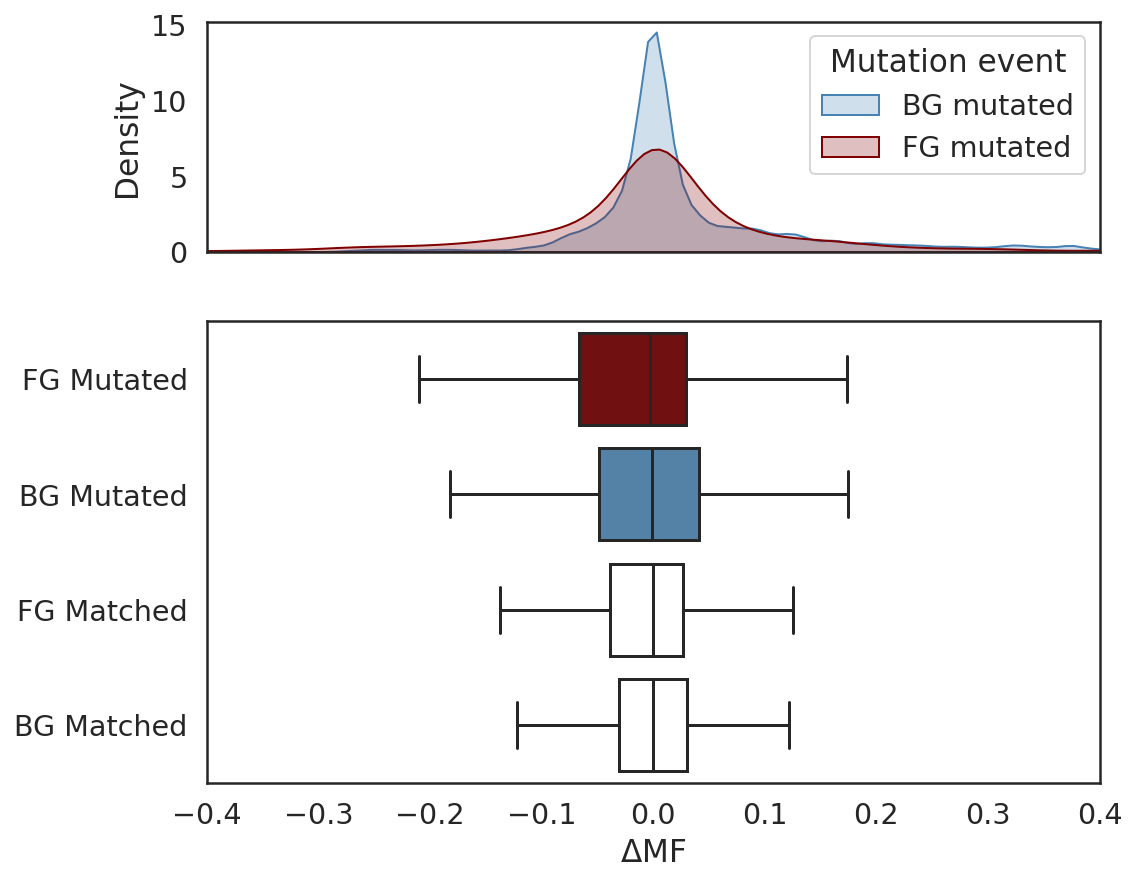

In [166]:
# make second axes taller
fig, axes = plt.subplots(2,1, figsize=(8, 7), sharex=True, gridspec_kw={'height_ratios': [1, 2]})
metric = 'mean_dmf'
mut = dist_all_mean_metrics_df.loc[
    (dist_all_mean_metrics_df.mutated_sample == True)
    & (dist_all_mean_metrics_df.num_comparison_sites >= 2)
    & (dist_all_mean_metrics_df.Relation_to_UCSC_CpG_Island == 'Island')
    ]
mut = mut.rename(columns={'is_background': 'Mutation event'})#.replace({'Mutation event': {True: 'BG mutated samples', False: 'FG mutated samples'}})
# make FG mutated samples in front
sns.kdeplot(data=mut, x=metric, hue='Mutation event', common_norm=False, palette=[ 'maroon', 'steelblue'], fill=True, ax = axes[0])
#sns.histplot(data=mut, x=metric, hue='Mutation event', common_norm=False, palette=['maroon', 'steelblue'], fill=True, ax = axes[0], stat='probability', bins=50, log_scale=[False, False], common_bins=True)
# set xlim
axes[0].set_xlim(-.4, .4)
# write delta in greek sybol
axes[0].set_xlabel('Z-score of methylation change')
# change legend labels
axes[0].legend(['BG mutated', 'FG mutated'], loc='upper right', title='Mutation event')


# plot boxplots of mean_zdmf for each of the 4 groups: FG mutated, BG mutated, FG matched, BG matched
to_plot = dist_all_mean_metrics_df.loc[
    dist_all_mean_metrics_df.num_comparison_sites >= 2
    & (dist_all_mean_metrics_df.Relation_to_UCSC_CpG_Island == 'Island')
    ]
to_plot = to_plot[[metric, 'is_background', 'mutated_sample' ]].rename(columns={'is_background': 'FG/BG'}).replace({'FG/BG': {True: 'BG', False: 'FG'}})
to_plot = to_plot.rename(columns={'mutated_sample': 'Sample'}).replace({'Sample': {True: 'Mutated', False: 'Matched'}})
to_plot['combined'] = to_plot['FG/BG'] + ' ' + to_plot['Sample']

# create a pallette with the first as white, the second as steelblue, the third as white, and the fourth as maroon
pallette = [ 'maroon', 'steelblue', 'white','white']
sns.boxplot(data=to_plot, x=metric, y='combined', orient='h', ax = axes[1], showfliers=False, palette=pallette, order = ['FG Mutated', 'BG Mutated', 'FG Matched', 'BG Matched'])
# angle y ticks and anchor
axes[1].tick_params(axis='y', labelrotation=0)
# remove ylabel 
axes[1].set_ylabel('')
axes[1].set_xlabel(r'$\Delta$MF')

##### Characteristics of large effect mut events

In [ ]:
# Only C>T mutations
# Only mutations in high/low density areas of (measured) CpGs
    # number of comparison sites

In [ ]:
# get only FG-mut 
fg_mut_mean_metrics = dist_all_mean_metrics_df.loc[(dist_all_mean_metrics_df.is_background == False) & (dist_all_mean_metrics_df.mutated_sample == True)]
fg_mut_mean_metrics.reset_index(inplace=True)
# add mut_)event column
#all_mut_w_age_df['mut_event'] = all_mut_w_age_df['case_submitter_id'] + '_' + all_mut_w_age_df['mut_loc']
# merge with mutations to get DNA_VAF, dataset, and mutaiton
#fg_mut_mean_metrics = fg_mut_mean_metrics.merge(all_mut_w_age_df[['mutation', 'dataset', 'DNA_VAF', 'mut_event']], on='mut_event', how='left')
# merge with comparison sites to get number of comparison sites, reference, alt, and age_at_index, number of matched samples
fg_mut_mean_metrics = fg_mut_mean_metrics.merge(dist_all_comparison_site_df[['mut_event', 'num_matched_samples', 'reference', 'alt' ,'age_at_index','comparison_dists' ]], on='mut_event', how='left')
fg_mut_mean_metrics['num_comparison_sites'] = fg_mut_mean_metrics['comparison_dists'].apply(lambda x: len(x))
fg_mut_mean_metrics['mean_dist'] = fg_mut_mean_metrics['comparison_dists'].apply(lambda x: np.mean(x))
fg_mut_mean_metrics['median_dist'] = fg_mut_mean_metrics['comparison_dists'].apply(lambda x: np.median(x))


In [55]:
# get only FG-mut 
fg_mut_mean_metrics = dist_all_mean_metrics_df.loc[(dist_all_mean_metrics_df.is_background == False) & (dist_all_mean_metrics_df.mutated_sample == True)]
fg_mut_mean_metrics.reset_index(inplace=True)
# add mut_)event column
#all_mut_w_age_df['mut_event'] = all_mut_w_age_df['case_submitter_id'] + '_' + all_mut_w_age_df['mut_loc']
# merge with mutations to get DNA_VAF, dataset, and mutaiton
#fg_mut_mean_metrics = fg_mut_mean_metrics.merge(all_mut_w_age_df[['mutation', 'dataset', 'DNA_VAF', 'mut_event']], on='mut_event', how='left')
# merge with comparison sites to get number of comparison sites, reference, alt, and age_at_index, number of matched samples
fg_mut_mean_metrics = fg_mut_mean_metrics.merge(dist_all_comparison_site_df[['mut_event', 'num_matched_samples', 'reference', 'alt' ,'age_at_index','comparison_dists' ]], on='mut_event', how='left')
fg_mut_mean_metrics['num_comparison_sites'] = fg_mut_mean_metrics['comparison_dists'].apply(lambda x: len(x))
fg_mut_mean_metrics['mean_dist'] = fg_mut_mean_metrics['comparison_dists'].apply(lambda x: np.mean(x))
fg_mut_mean_metrics['median_dist'] = fg_mut_mean_metrics['comparison_dists'].apply(lambda x: np.median(x))


In [ ]:
fig, axes = plt.subplots(figsize=(14, 5))
sns.boxplot(data=fg_mut_mean_metrics, x='dataset', y='mean_zdmf', ax = axes, showfliers=False)

<AxesSubplot:xlabel='mutation', ylabel='mean_abs_zdmf'>

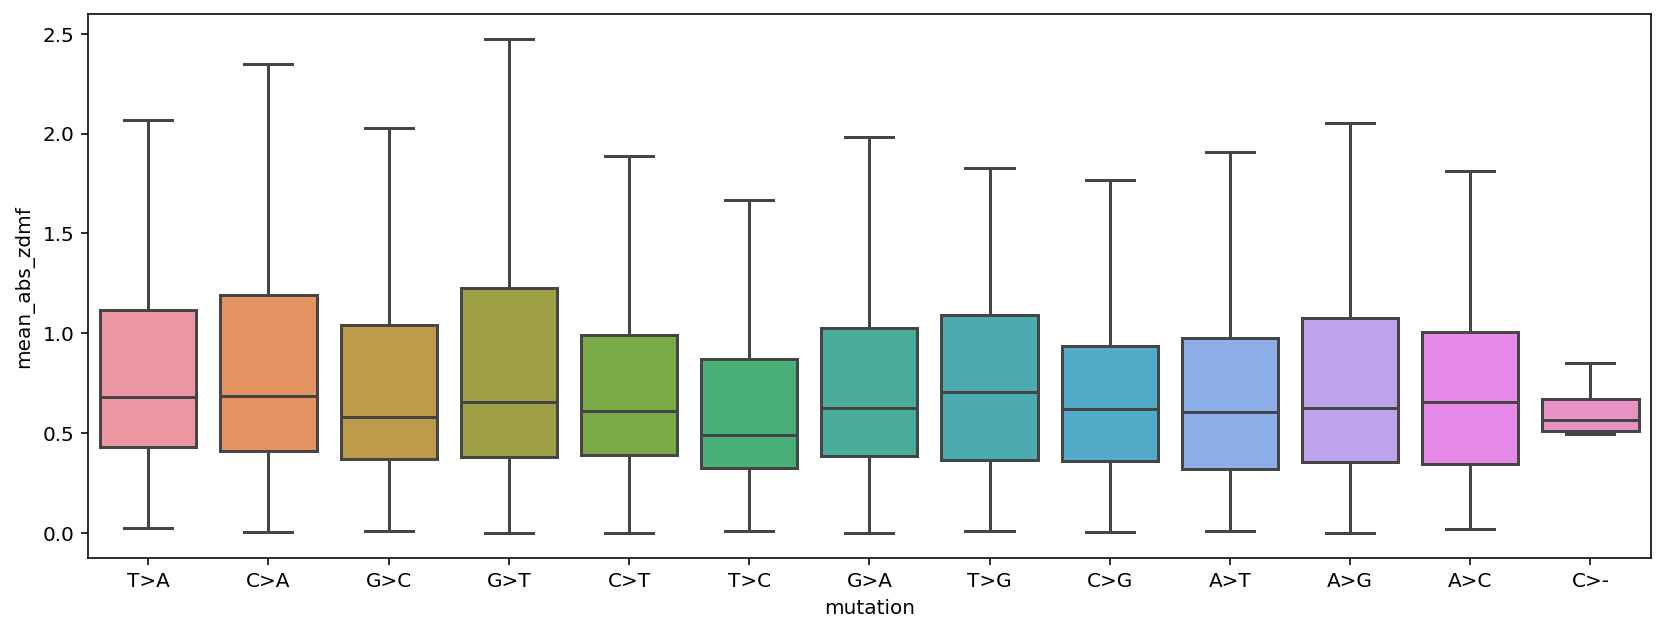

In [162]:
fig, axes = plt.subplots(figsize=(14, 5))
sns.boxplot(data=fg_mut_mean_metrics, x='mutation', y='mean_abs_zdmf', ax = axes, showfliers=False)

<AxesSubplot:xlabel='reference', ylabel='mean_abs_zdmf'>

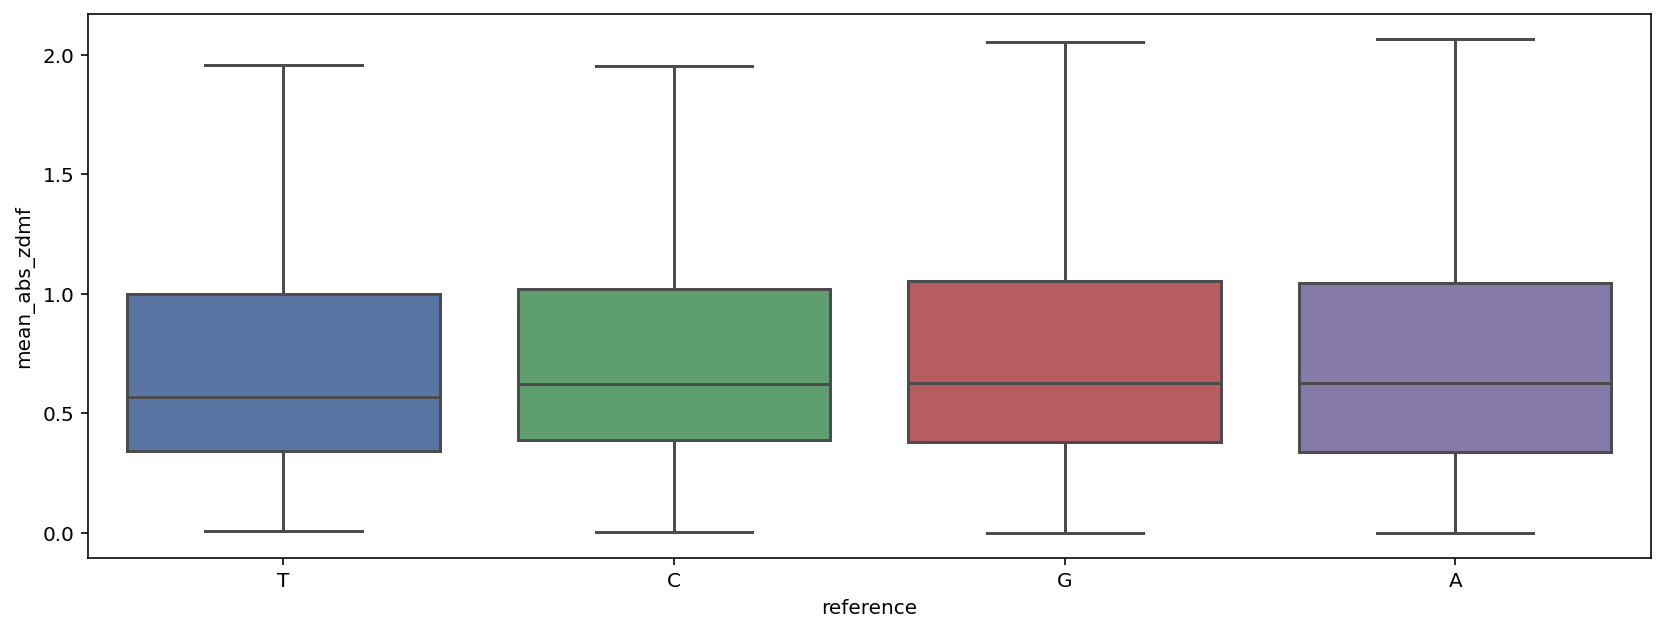

In [216]:
fig, axes = plt.subplots(figsize=(14, 5))
sns.boxplot(data=fg_mut_mean_metrics, x='reference', y='mean_abs_zdmf', ax = axes, showfliers=False)

<AxesSubplot:xlabel='alt', ylabel='mean_abs_zdmf'>

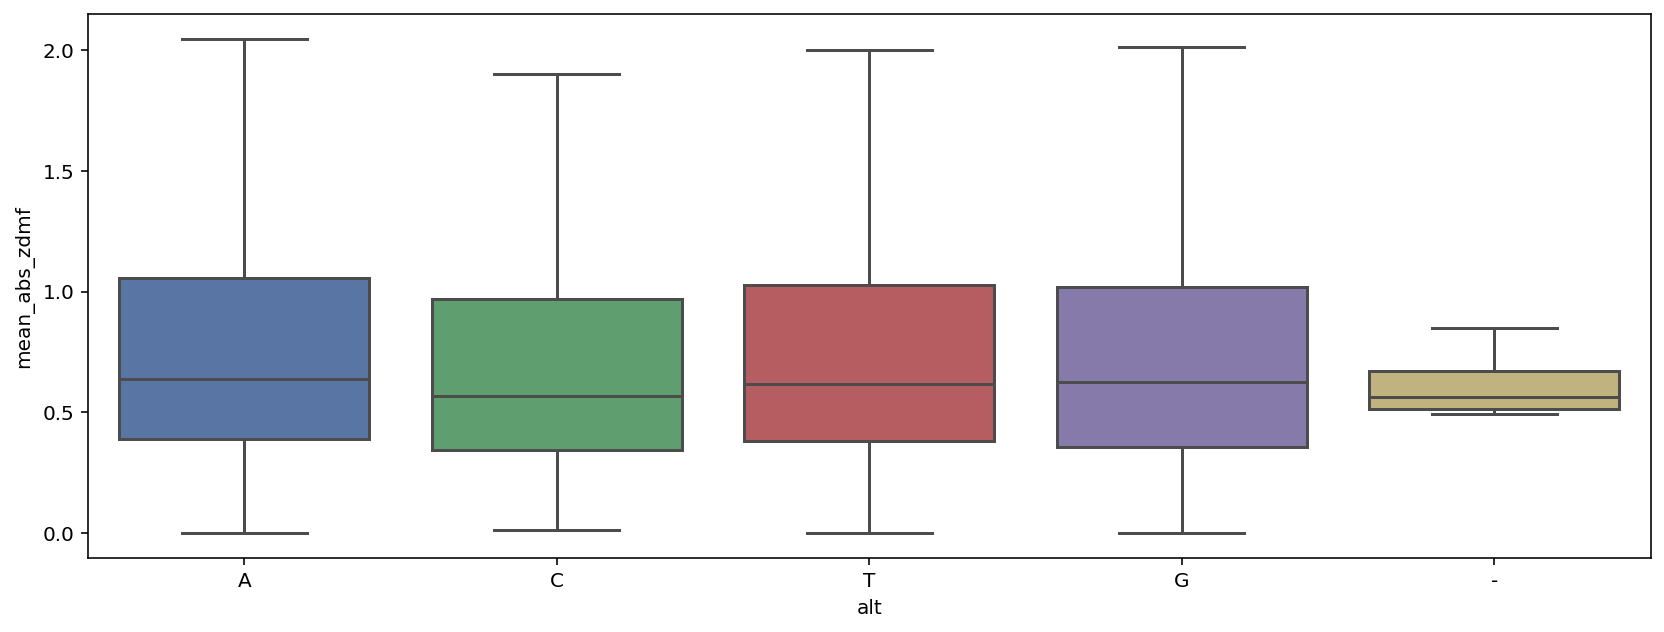

In [217]:
fig, axes = plt.subplots(figsize=(14, 5))
sns.boxplot(data=fg_mut_mean_metrics, x='alt', y='mean_abs_zdmf', ax = axes, showfliers=False)

SpearmanrResult(correlation=0.03562098833922425, pvalue=0.005029721726691721)

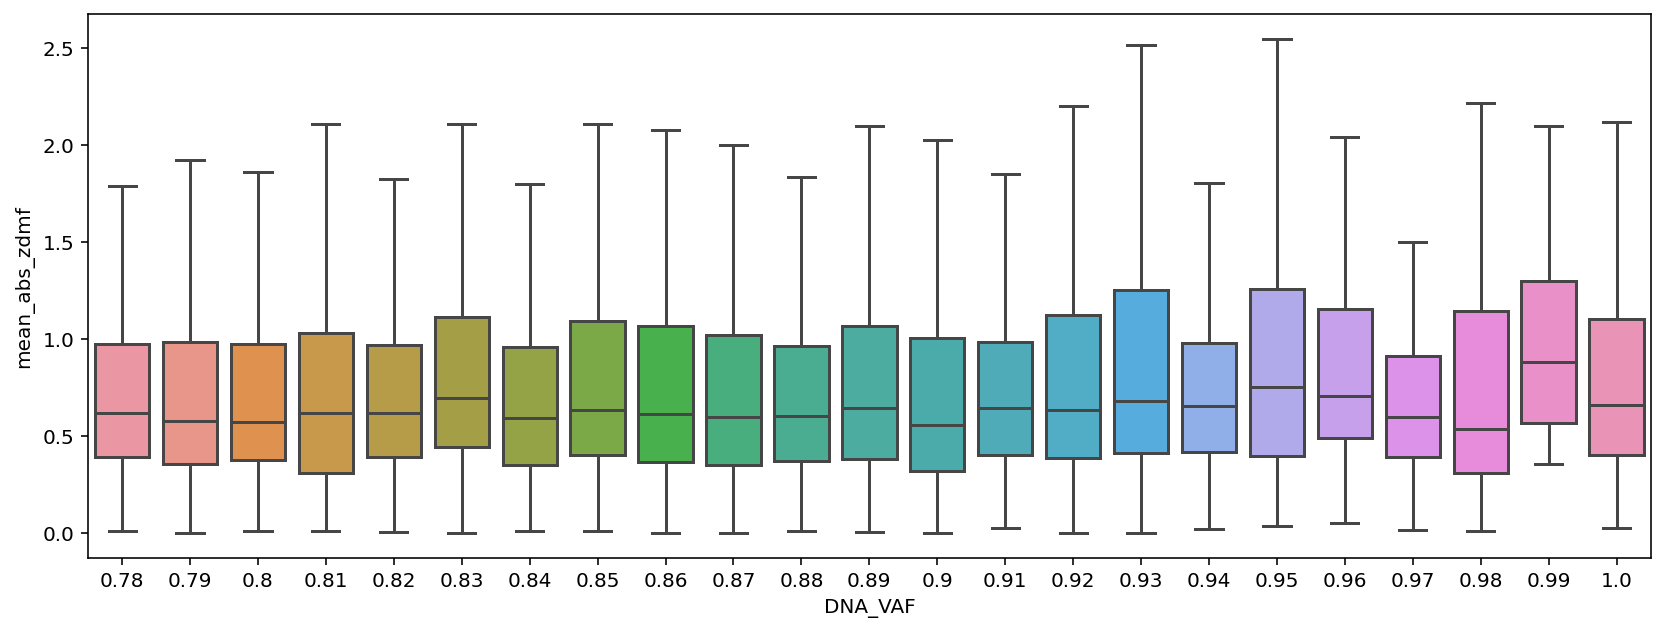

In [164]:
fig, axes = plt.subplots(figsize=(14, 5))
sns.boxplot(data=fg_mut_mean_metrics, x='DNA_VAF', y='mean_abs_zdmf', ax = axes, showfliers=False)
spearmanr(fg_mut_mean_metrics['DNA_VAF'], fg_mut_mean_metrics['mean_abs_zdmf'])

SpearmanrResult(correlation=0.08404714264041528, pvalue=3.396345509487426e-11)

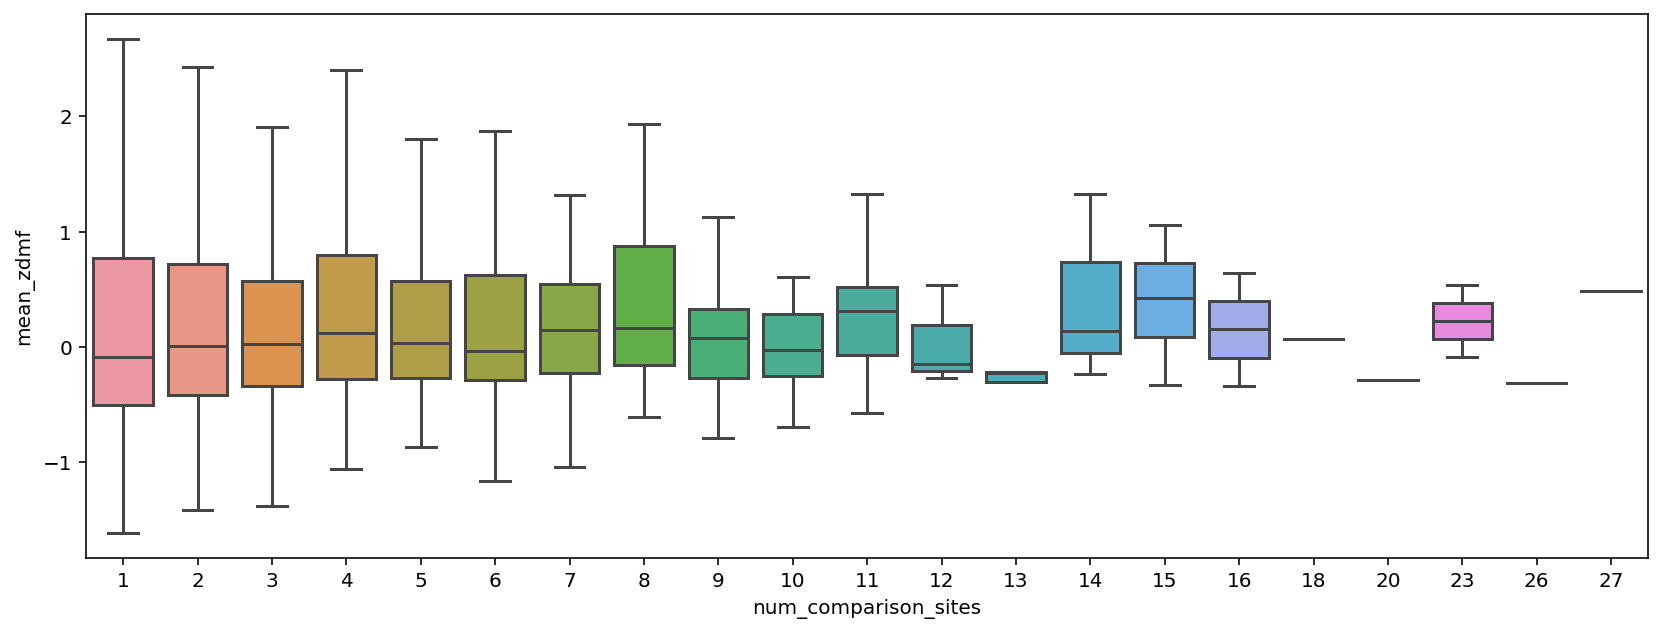

In [112]:
fig, axes = plt.subplots(figsize=(14, 5))
sns.boxplot(data=fg_mut_mean_metrics.loc[fg_mut_mean_metrics.num_comparison_sites <= 100], x='num_comparison_sites', y='mean_zdmf', ax = axes, showfliers=False)
spearmanr(fg_mut_mean_metrics.loc[fg_mut_mean_metrics.num_comparison_sites <= 100]['num_comparison_sites'], fg_mut_mean_metrics.loc[fg_mut_mean_metrics.num_comparison_sites <= 100]['mean_zdmf'])

SpearmanrResult(correlation=-0.031095437917800905, pvalue=0.014343028642795094)

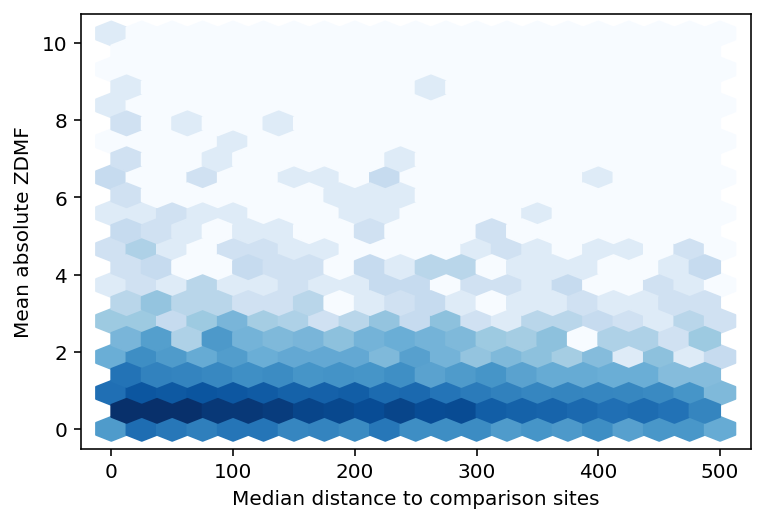

In [211]:
plt.hexbin(fg_mut_mean_metrics['median_dist'].abs(), fg_mut_mean_metrics['mean_abs_zdmf'], gridsize=20, cmap='Blues', bins = 'log')
plt.xlabel('Median distance to comparison sites')
plt.ylabel('Mean absolute ZDMF')
spearmanr(fg_mut_mean_metrics['median_dist'].abs(), fg_mut_mean_metrics['mean_abs_zdmf'])


(0.029674622445455656, 0.01945866449233117)

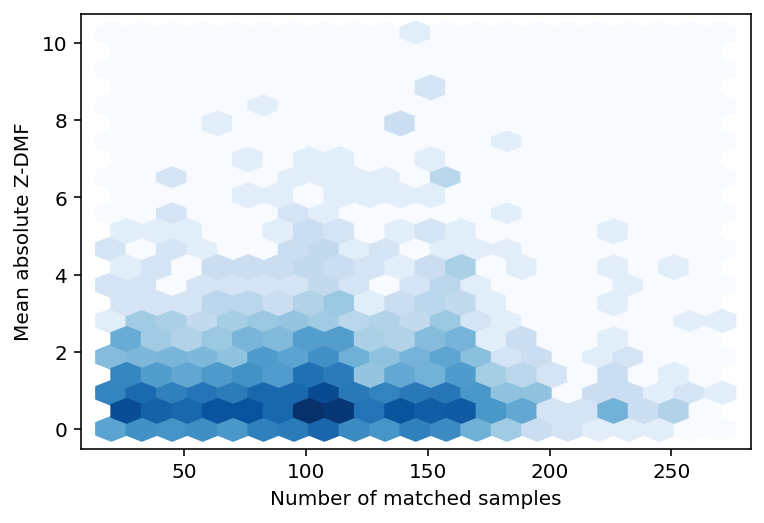

In [212]:
plt.hexbin(fg_mut_mean_metrics['num_matched_samples'], fg_mut_mean_metrics['mean_abs_zdmf'], gridsize=20, cmap='Blues', bins = 'log')
plt.xlabel('Number of matched samples')
plt.ylabel('Mean absolute Z-DMF')
pearsonr(fg_mut_mean_metrics['num_matched_samples'], fg_mut_mean_metrics['mean_abs_zdmf'])

(-0.007028479213153806, 0.5800455045909297)

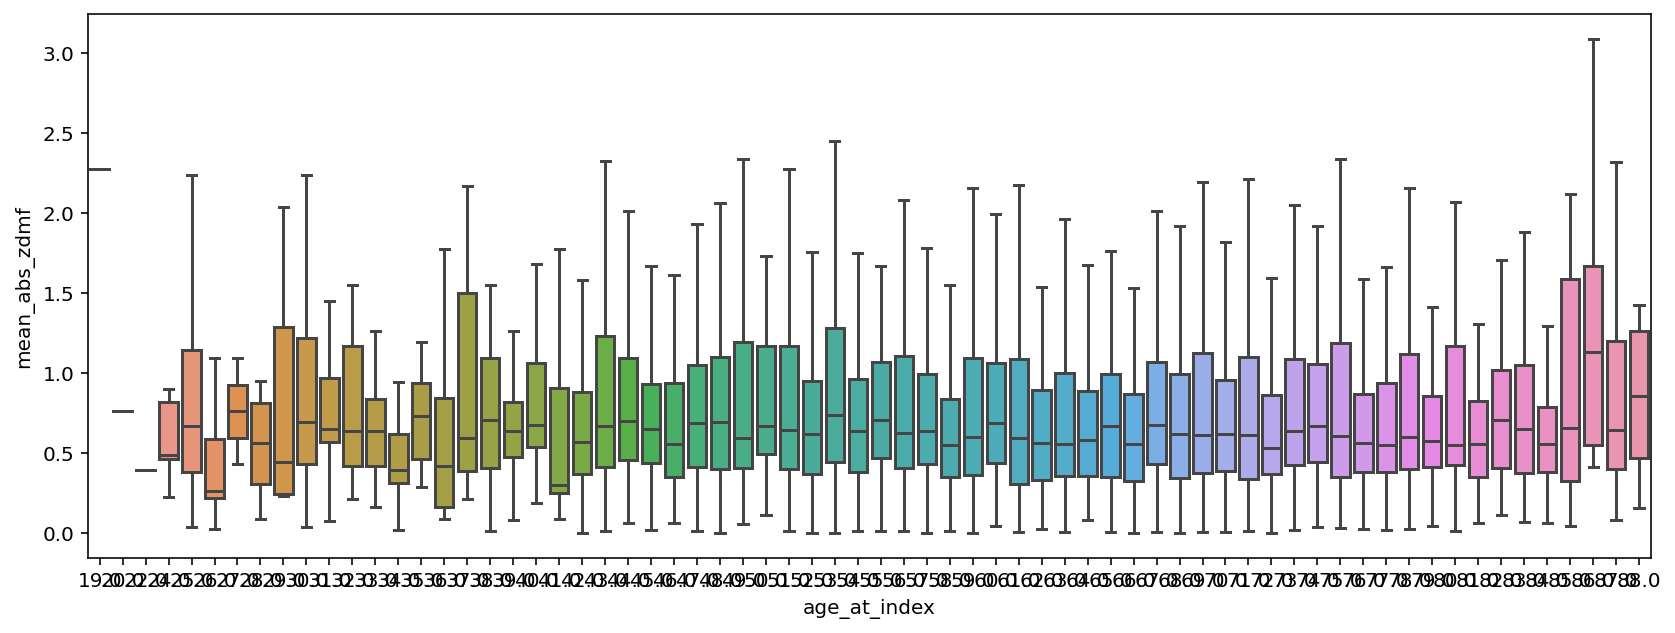

In [219]:
fig, axes = plt.subplots(figsize=(14, 5))
sns.boxplot(data=fg_mut_mean_metrics, x='age_at_index', y='mean_abs_zdmf', ax = axes, showfliers=False)
pearsonr(fg_mut_mean_metrics['age_at_index'], fg_mut_mean_metrics['mean_abs_zdmf'])

##### Test example

In [75]:
one_mut_event = all_mean_metrics_df.loc['TCGA-06-5408_10:127462500']
fg_mut = one_mut_event.loc[one_mut_event['mutated_sample'] == True]
fg_matched = one_mut_event.loc[one_mut_event['mutated_sample'] == False]

In [77]:
bg_mut_events = all_mean_metrics_df.loc[all_mean_metrics_df.index_event == 'TCGA-06-5408_10:127462500']
bg_muts = bg_mut_events.loc[bg_mut_events['mutated_sample'] == True]
bg_matched = bg_mut_events.loc[bg_mut_events['mutated_sample'] == False]

<AxesSubplot:>

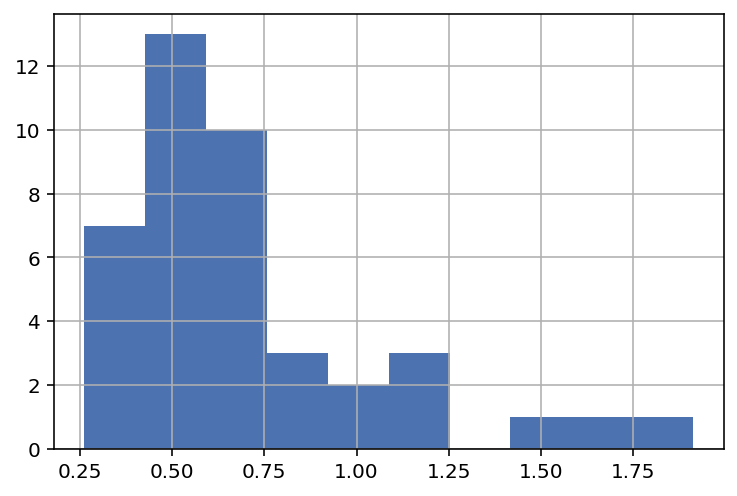

In [81]:
fg_matched['mean_abs_zdmf'].hist()

<AxesSubplot:>

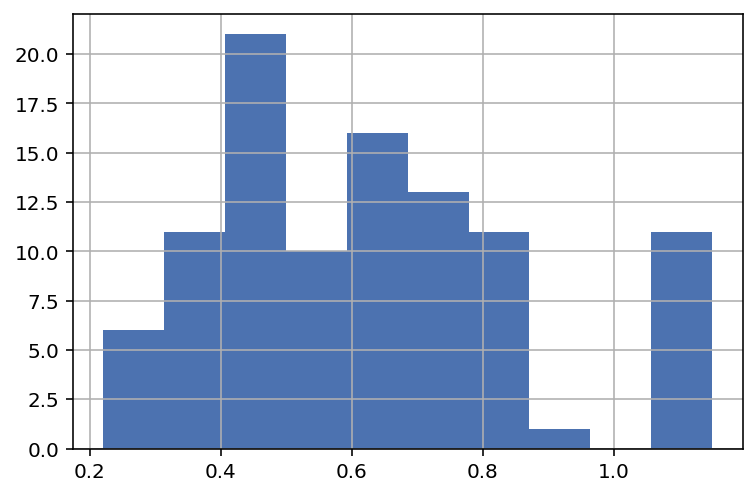

In [83]:
bg_muts['mean_abs_zdmf'].hist()

<AxesSubplot:>

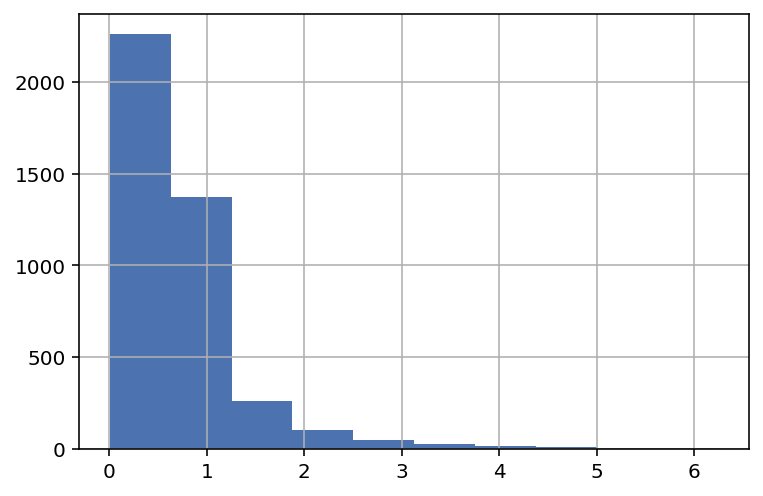

In [82]:
bg_matched['mean_abs_zdmf'].hist()

In [ ]:
# this but with the values scaled by the BG for that specific site 
# FG-mut: commparison sites
# FG-matched: commparison sites
# BG-mut: commparison sites
# BG-matched: commparison sites

# We are interested in if the FG-mut comparison sites are more different from the FG-matched comparison sites than the BG-mut comparison sites are from the BG-matched comparison sites
# the magnitude of the difference can be captured by ZMF, because this is the difference from mean scaled by the standard deviation of the site
# how can this value get 

##### volcano plot way

In [36]:
mut_scan = compute_comethylation.mutationScan(
    all_mut_w_age_df, illumina_cpg_locs_df, 
    all_methyl_age_df_t, corr_dir = corr_dir,
    age_bin_size = 10, max_dist = 500,
    num_correl_sites = 10, num_background_events = 3,
    matched_sample_num = 20
    )

In [47]:
# correct all pvalues using the whole background distribution
all_metrics_df_corrected_one_background = mut_scan.correct_pvals(dist_all_metrics_df, one_background=True, pvals_to_correct=['delta_mf_median_pval2', 'abs_delta_mf_median_pval','abs_delta_mf_mean_pval' ,'zscore_median_pval2','zscore_mean_pval' ])

/cellar/users/zkoch/methylation_and_mutation/source_files/compute_comethylation.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_muts_df['abs_' + effect_col] = real_muts_df[effect_col].abs()


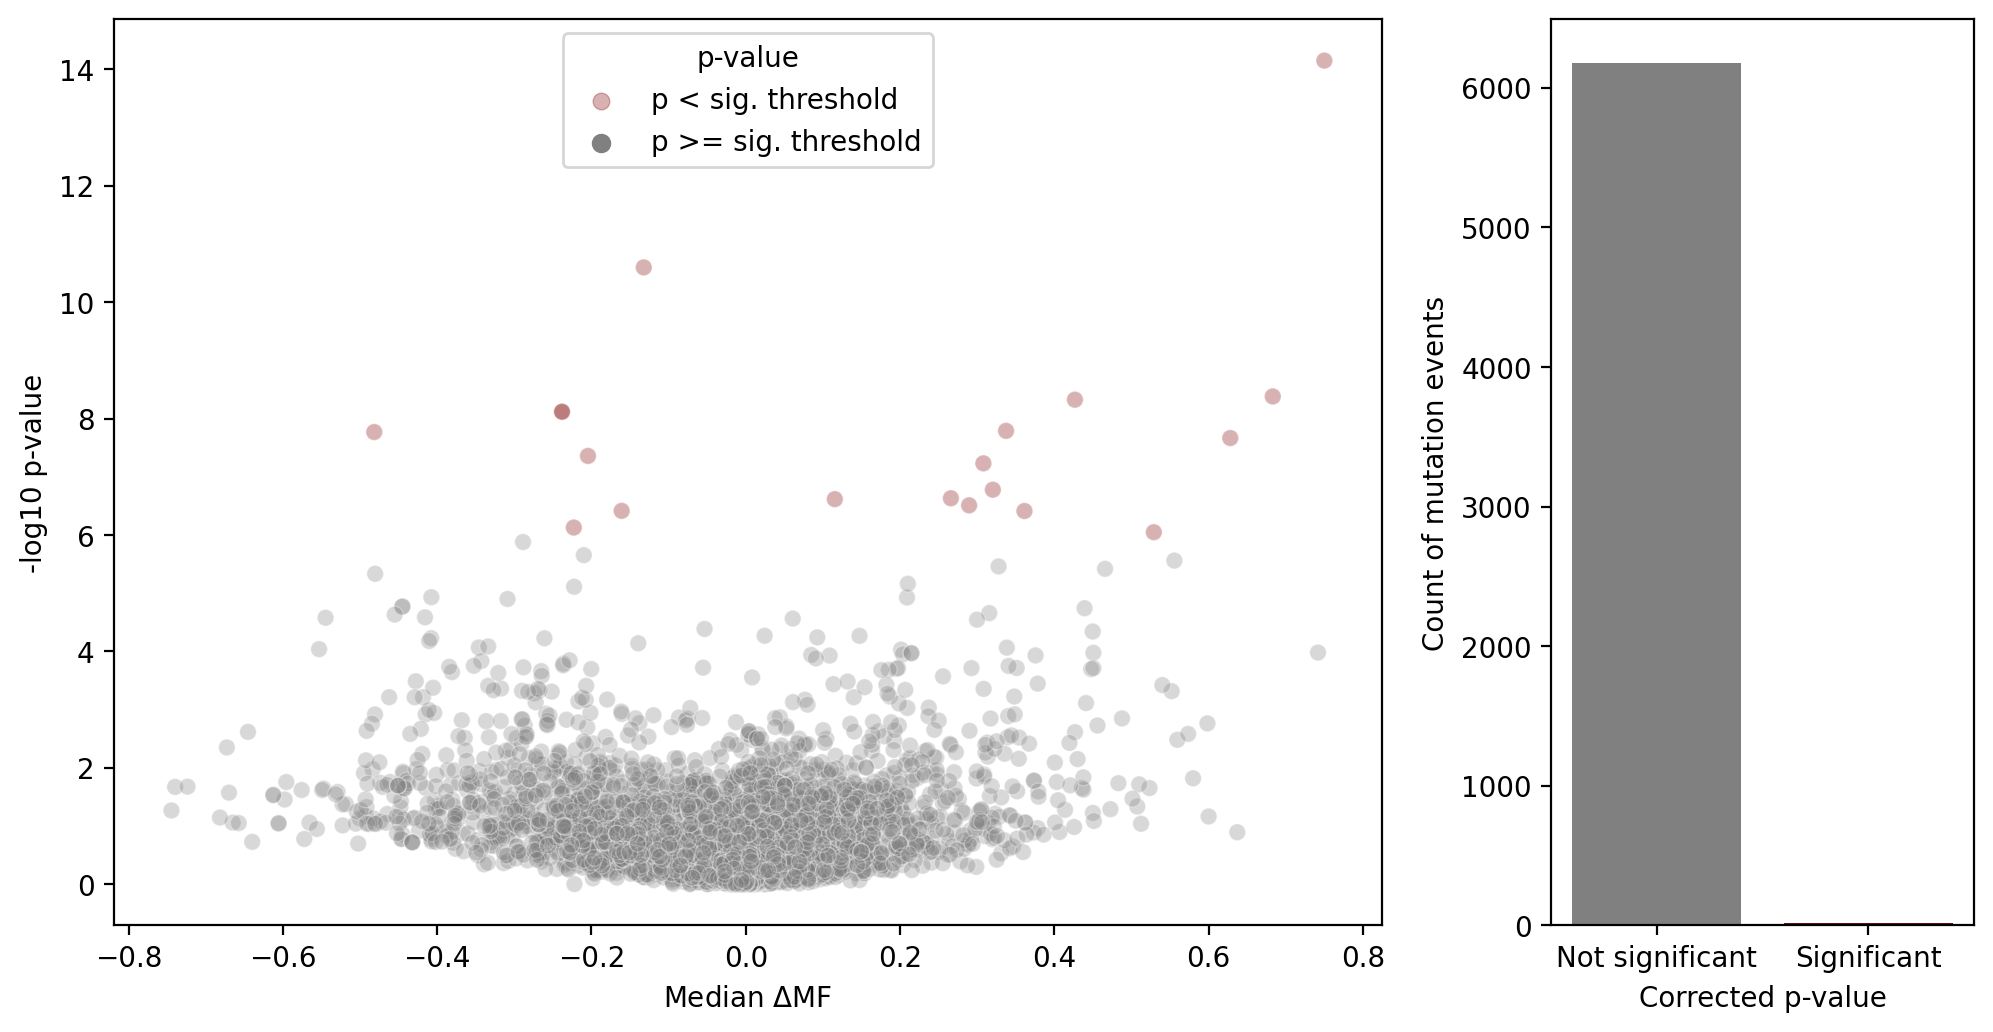

In [48]:
grouped_volc_metrics = mut_scan.volcano_plot(
    all_metrics_df_corrected_one_background,
    pval_col = 'delta_mf_median_pval2', sig_col = 'delta_mf_median_pval2_sig',
    effect_col = 'delta_mf_median'
    )

In [44]:
# correct all pvalues using the whole background distribution
real_muts_corrected_each_background = mut_scan.correct_pvals(dist_all_metrics_df, one_background=False, pvals_to_correct=['delta_mf_median_pval2', 'abs_delta_mf_median_pval','abs_delta_mf_mean_pval', 'zscore_median_pval2', 'zscore_mean_pval' ])

/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/pandas/core/frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


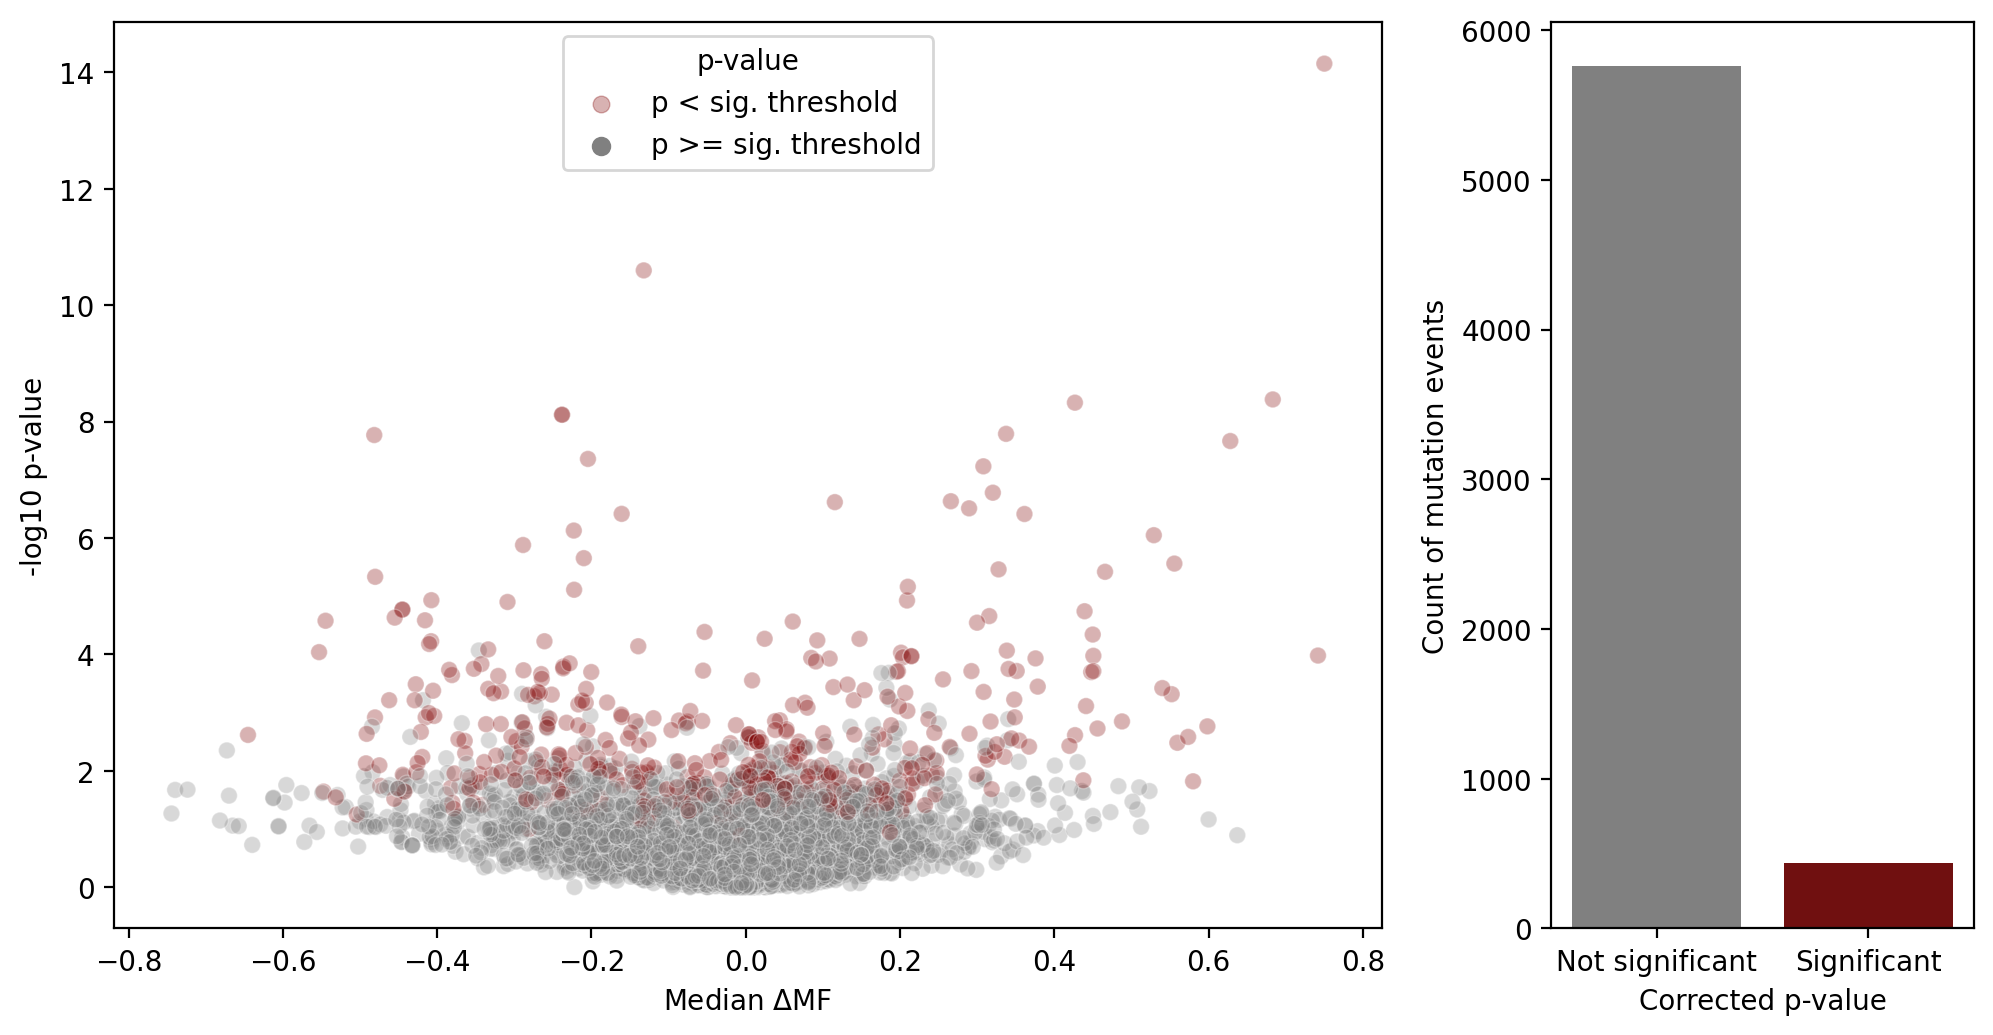

In [46]:
grouped_volc_metrics = mut_scan.volcano_plot(
    real_muts_corrected_each_background,
    pval_col = 'delta_mf_median_pval2', sig_col = 'delta_mf_median_pval2_sig', effect_col = 'delta_mf_median'
    )

### Corr

In [30]:
from scipy.stats import norm
# map zscore_abs_delta_mf_mean to pvalue, one sided,
# here the larger the zscore, the more significant the difference, and so the smaller the pvalue
all_metrics_df['zscore_abs_delta_mf_mean_pval'] = all_metrics_df['zscore_abs_delta_mf_mean'].apply(lambda x: 1 - norm.cdf(x))

In [47]:
all_comparison_site_df.sort_values('DNA_VAF', ascending=False, inplace=True)
all_comparison_site_df.reset_index(inplace=True, drop=True)

In [62]:
all_comparison_site_df_sub = all_comparison_site_df.loc[(all_comparison_site_df['DNA_VAF'] >= 0.4) | (all_comparison_site_df['is_background'] == True)]

In [74]:
all_mean_metrics_df_sub = all_mean_metrics_df.reset_index()

In [75]:
all_mean_metrics_df_sub2 = all_mean_metrics_df_sub.loc[all_mean_metrics_df_sub['mut_event'].isin(all_comparison_site_df_sub['mut_event'])]

In [137]:
# get the mean deltaMf across all CpGs for each sample
all_metrics_df['abs_delta_mf_median'] = all_metrics_df['delta_mf_median'].abs()
all_metrics_df['abs_zscore_abs_delta_mf_median'] = all_metrics_df['zscore_abs_delta_mf_median'].abs()

grouped_all_metrics_df = all_metrics_df.groupby(['mut_event', 'sample'])

mean_by_sample = grouped_all_metrics_df[['delta_mf_median', 'zscore_abs_delta_mf_median', 'abs_delta_mf_median', 'abs_zscore_abs_delta_mf_median']].mean()
mean_by_sample.columns = ['mean_dmf', 'mean_zdmf', 'mean_abs_dmf', 'mean_abs_zdmf']
median_by_sample = grouped_all_metrics_df[['delta_mf_median', 'zscore_abs_delta_mf_median', 'abs_delta_mf_median', 'abs_zscore_abs_delta_mf_median']].median()
median_by_sample.columns = ['median_dmf', 'median_zdmf', 'median_abs_dmf', 'median_abs_zdmf']

# merge these dfs 
mean_metrics_df = mean_by_sample.merge(median_by_sample, left_index=True, right_index=True)

mut_event_to_background_map = all_metrics_df.drop_duplicates(subset=['mut_event', 'sample'])
mut_event_to_background_map.set_index(['mut_event', 'sample'], inplace=True)
all_mean_metrics_df = mean_metrics_df.merge(mut_event_to_background_map[['is_background', 'index_event', 'mutated_sample']], left_index=True, right_index=True)

In [138]:
all_mean_metrics_df.to_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/correl_based_10Top/all_mean_metrics_df.parquet')
all_mean_metrics_df_sub2.to_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/correl_based_10Top/all_mean_metrics_df_sub2.parquet')

In [14]:
all_mean_metrics_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/correl_based_10Top/all_mean_metrics_df.parquet')

In [81]:
# test for a difference between mean metric value across each set of comparison sites
mean_tests_dict = {}
# for each metric, print the t-test and wilcoxon test p-values for FG mut vs FG matched, and BG mut vs BG matched
for metric in ['mean_dmf', 'mean_zdmf',]: # 'median_dmf','median_zdmf','mean_abs_dmf', 'mean_abs_zdmf', 'median_abs_dmf', 'median_abs_zdmf'
    # is the mutated sample, background is false
    fg_mut = all_mean_metrics_df_sub2.loc[(all_mean_metrics_df_sub2['is_background'] == False) & (all_mean_metrics_df_sub2['mutated_sample'] == True), metric]
    fg_matched = all_mean_metrics_df_sub2.loc[(all_mean_metrics_df_sub2['is_background'] == False) & (all_mean_metrics_df_sub2['mutated_sample'] == False), metric]
    # is the mutated sample, background is true
    bg_mut = all_mean_metrics_df_sub2.loc[(all_mean_metrics_df_sub2['is_background'] == True) & (all_mean_metrics_df_sub2['mutated_sample'] == True), metric]
    bg_matched = all_mean_metrics_df_sub2.loc[(all_mean_metrics_df_sub2['is_background'] == True) & (all_mean_metrics_df_sub2['mutated_sample'] == False), metric]
    
    # FG mut vs FG matched
    fg_ttest = ttest_ind(fg_mut, fg_matched, alternative = 'greater', equal_var=False).pvalue
    fg_mwu = mannwhitneyu(fg_mut, fg_matched, alternative = 'greater').pvalue
    fg_effect_size = (fg_mut.mean() - fg_matched.mean())
    # BG mut vs BG matched
    bg_ttest = ttest_ind(bg_mut, bg_matched, alternative = 'greater', equal_var=False).pvalue
    bg_mwu = mannwhitneyu(bg_mut, bg_matched, alternative = 'greater').pvalue
    bg_effect_size = (bg_mut.mean() - bg_matched.mean())
    
    # anova between all 4 groups
    anova = stats.f_oneway(fg_mut, fg_matched, bg_mut, bg_matched)
    # post-hoc tukey test
    groups_df = pd.concat([fg_mut, fg_matched, bg_mut, bg_matched]).reset_index()
    groups_df['group'] = ['fg_mut'] * len(fg_mut) + ['fg_matched'] * len(fg_matched) + ['bg_mut'] * len(bg_mut) + ['bg_matched'] * len(bg_matched)
    tukey = pairwise_tukeyhsd(groups_df[metric], groups_df['group'], alpha=0.05)

    mean_tests_dict[metric] = {'fg_ttest': fg_ttest, 'fg_mwu': fg_mwu, 'fg_effect_size': fg_effect_size, 'bg_ttest': bg_ttest, 'bg_mwu': bg_mwu, 'bg_effect_size': bg_effect_size, 'anova': anova, 'tukey': tukey}
    print("done with {}".format(metric), flush=True)
mean_tests_df = pd.DataFrame(mean_tests_dict).T
mean_tests_df['effect_ratio'] = mean_tests_df['fg_effect_size'] / mean_tests_df['bg_effect_size']

done with mean_dmf
done with mean_zdmf


In [5]:
mean_tests_df = pd.read_pickle('/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/correl_based_10Top/mean_tests_df.pkl')

In [183]:
mean_tests_df.loc['mean_dmf', 'tukey'].summary()

group1,group2,meandiff,p-adj,lower,upper,reject
bg_matched,bg_mut,-0.0007,0.0,-0.001,-0.0004,True
bg_matched,fg_matched,-0.0135,0.0,-0.0142,-0.0129,True
bg_matched,fg_mut,-0.0319,0.0,-0.0381,-0.0257,True
bg_mut,fg_matched,-0.0128,0.0,-0.0136,-0.0121,True
bg_mut,fg_mut,-0.0312,0.0,-0.0374,-0.025,True
fg_matched,fg_mut,-0.0184,0.0,-0.0246,-0.0121,True


In [184]:
mean_tests_df.loc['mean_dmf', 'tukey'].pvalues

array([1.41386169e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.87103674e-13])

In [182]:
dist_mean_tests_df.loc['mean_dmf', 'tukey'].summary()

group1,group2,meandiff,p-adj,lower,upper,reject
bg_matched,bg_mut,0.0027,0.0,0.0023,0.0032,True
bg_matched,fg_matched,-0.0083,0.0,-0.0089,-0.0077,True
bg_matched,fg_mut,-0.0218,0.0,-0.0279,-0.0158,True
bg_mut,fg_matched,-0.011,0.0,-0.0118,-0.0103,True
bg_mut,fg_mut,-0.0246,0.0,-0.0306,-0.0185,True
fg_matched,fg_mut,-0.0135,0.0,-0.0196,-0.0075,True


In [185]:
dist_mean_tests_df.loc['mean_dmf', 'tukey'].pvalues

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.75633936e-08])

Text(0.5, 0, '$\\Delta$MF')

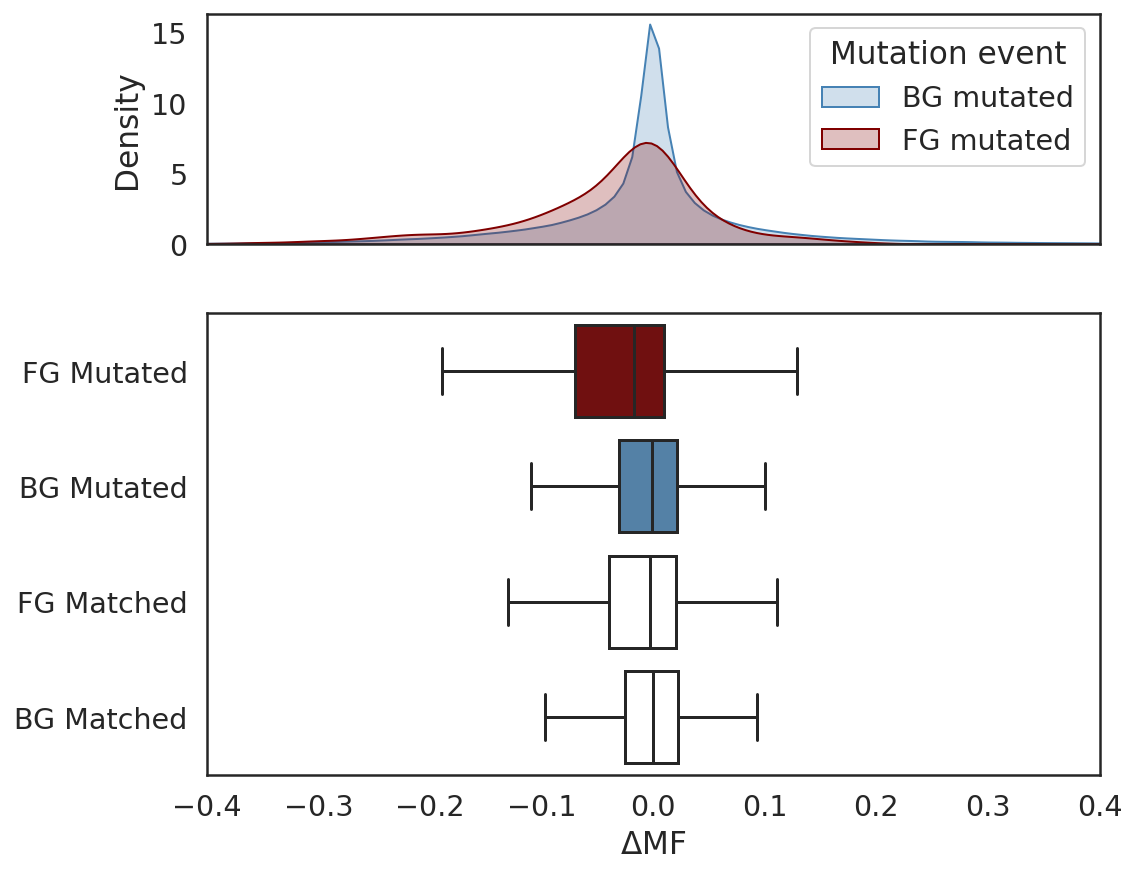

In [167]:
# make second axes taller
fig, axes = plt.subplots(2,1, figsize=(8, 7), sharex=True, gridspec_kw={'height_ratios': [1, 2]})
metric = 'mean_dmf'
mut = all_mean_metrics_df_sub2.loc[all_mean_metrics_df_sub2.mutated_sample == True]
mut = mut.rename(columns={'is_background': 'Mutation event'})#.replace({'Mutation event': {True: 'BG mutated samples', False: 'FG mutated samples'}})
# make FG mutated samples in front
sns.kdeplot(data=mut, x=metric, hue='Mutation event', common_norm=False, palette=[ 'maroon', 'steelblue'], fill=True, ax = axes[0])
# set xlim
axes[0].set_xlim(-.4, .4)
# write delta in geek sybol
axes[0].set_xlabel('Z-score of methylation change')
# change legend labels
axes[0].legend(['BG mutated', 'FG mutated'], loc='upper right', title='Mutation event')


# plot boxplots of mean_zdmf for each of the 4 groups: FG mutated, BG mutated, FG matched, BG matched
to_plot = all_mean_metrics_df_sub2[[metric,'is_background', 'mutated_sample' ]].rename(columns={'is_background': 'FG/BG'}).replace({'FG/BG': {True: 'BG', False: 'FG'}})
to_plot = to_plot.rename(columns={'mutated_sample': 'Sample'}).replace({'Sample': {True: 'Mutated', False: 'Matched'}})
to_plot['combined'] = to_plot['FG/BG'] + ' ' + to_plot['Sample']

# create a pallette with the first as white, the second as steelblue, the third as white, and the fourth as maroon
pallette = [ 'maroon', 'steelblue', 'white','white']
sns.boxplot(data=to_plot, x=metric, y='combined', orient='h', ax = axes[1], showfliers=False, palette=pallette, order = ['FG Mutated', 'BG Mutated', 'FG Matched', 'BG Matched'])
# remove ylabel 
axes[1].tick_params(axis='y', labelrotation=0)
axes[1].set_ylabel('')
# delta in geek symbol
axes[1].set_xlabel(r'$\Delta$MF')

### lit

In [28]:
# get the mean deltaMf across all CpGs for each sample
lit_all_metrics_df['abs_delta_mf_median'] = lit_all_metrics_df['delta_mf_median'].abs()
lit_all_metrics_df['abs_zscore_abs_delta_mf_median'] = lit_all_metrics_df['zscore_abs_delta_mf_median'].abs()

grouped_lit_all_metrics_df = lit_all_metrics_df.groupby(['mut_event', 'sample'])
mean_by_sample = grouped_lit_all_metrics_df[['delta_mf_median', 'zscore_abs_delta_mf_median', 'abs_delta_mf_median', 'abs_zscore_abs_delta_mf_median']].mean()
mean_by_sample.columns = ['mean_dmf', 'mean_zdmf', 'mean_abs_dmf', 'mean_abs_zdmf']
median_by_sample = grouped_lit_all_metrics_df[['delta_mf_median', 'zscore_abs_delta_mf_median', 'abs_delta_mf_median', 'abs_zscore_abs_delta_mf_median']].median()
median_by_sample.columns = ['median_dmf', 'median_zdmf', 'median_abs_dmf', 'median_abs_zdmf']

# merge these dfs 
lit_mean_metrics_df = mean_by_sample.merge(median_by_sample, left_index=True, right_index=True)

mut_event_to_background_map = lit_all_metrics_df.drop_duplicates(subset=['mut_event', 'sample'])
mut_event_to_background_map.set_index(['mut_event', 'sample'], inplace=True)
lit_all_mean_metrics_df = lit_mean_metrics_df.merge(mut_event_to_background_map[['is_background', 'index_event', 'mutated_sample']], left_index=True, right_index=True)

NameError: name 'lit_all_metrics_df' is not defined

In [170]:
lit_all_mean_metrics_df.to_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/lit_all_mean_metrics_df.parquet')

In [27]:
lit_all_mean_metrics_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/lit_all_mean_metrics_df.parquet')

In [175]:
lit_all_mean_metrics_df.loc[(~lit_all_mean_metrics_df.is_background)]

mean_dmf  mean_zdmf  mean_abs_dmf  \
mut_event                sample                                            
TCGA-2G-AAGP_7:4998791   TCGA-2G-AAF8 -0.019058  -1.189159      0.019058   
                         TCGA-2G-AAFI  0.110693  -0.124681      0.110693   
                         TCGA-2G-AAFJ  0.048186  -0.850791      0.048186   
                         TCGA-2G-AAFL -0.096865  -0.285314      0.096865   
                         TCGA-2G-AAFM -0.137607   0.187976      0.137607   
...                                         ...        ...           ...   
TCGA-ZP-A9D4_10:79397504 TCGA-ZP-A9D4  0.036865  -0.161758      0.036865   
                         TCGA-ZS-A9CD -0.004693  -0.548353      0.004693   
                         TCGA-ZS-A9CE  0.008298  -0.505027      0.008298   
                         TCGA-ZS-A9CF  0.048617  -0.020538      0.048617   
                         TCGA-ZS-A9CG  0.019567  -0.369615      0.019567   

                                       mean_abs_zdmf  median_dmf  median_zdmf  \
mut_event                sample                                                 
TCGA-2G-AAGP_7:4998791   TCGA-2G-AAF8       1.189159   -0.019058    -1.189159   
                         TCGA-2G-AAFI       0.124681    0.110693    -0.124681   
                         TCGA-2G-AAFJ       0.850791    0.048186    -0.850791   
                         TCGA-2G-AAFL       0.285314   -0.096865    -0.285314   
                         TCGA-2G-AAFM       0.187976   -0.137607     0.187976   
...                                              ...         ...          ...   
TCGA-ZP-A9D4_10:79397504 TCGA-ZP-A9D4       0.161758    0.036865    -0.161758   
                         TCGA-ZS-A9CD       0.548353   -0.004693    -0.548353   
                         TCGA-ZS-A9CE       0.505027    0.008298    -0.505027   
                         TCGA-ZS-A9CF       0.020538    0.048617    -0.020538   
                         TCGA-ZS-A9CG       0.369615    0.019567    -0.369615   

                                       median_abs_dmf  median_abs_zdmf  \
mut_event                sample                                          
TCGA-2G-AAGP_7:4998791   TCGA-2G-AAF8        0.019058         1.189159   
                         TCGA-2G-AAFI        0.110693         0.124681   
                         TCGA-2G-AAFJ        0.048186         0.850791   
                         TCGA-2G-AAFL        0.096865         0.285314   
                         TCGA-2G-AAFM        0.137607         0.187976   
...                                               ...              ...   
TCGA-ZP-A9D4_10:79397504 TCGA-ZP-A9D4        0.036865         0.161758   
                         TCGA-ZS-A9CD        0.004693         0.548353   
                         TCGA-ZS-A9CE        0.008298         0.505027   
                         TCGA-ZS-A9CF        0.048617         0.020538   
                         TCGA-ZS-A9CG        0.019567         0.369615   

                                       is_background index_event  \
mut_event                sample                                    
TCGA-2G-AAGP_7:4998791   TCGA-2G-AAF8          False        self   
                         TCGA-2G-AAFI          False        self   
                         TCGA-2G-AAFJ          False        self   
                         TCGA-2G-AAFL          False        self   
                         TCGA-2G-AAFM          False        self   
...                                              ...         ...   
TCGA-ZP-A9D4_10:79397504 TCGA-ZP-A9D4          False        self   
                         TCGA-ZS-A9CD          False        self   
                         TCGA-ZS-A9CE          False        self   
                         TCGA-ZS-A9CF          False        self   
                         TCGA-ZS-A9CG          False        self   

                                       mutated_sample  
mut_event                sample                        
TCGA-2G-AAGP_7:4998791   TCGA-2G-AAF

In [86]:
# test for a difference between mean metric value across each set of comparison sites

lit_mean_tests_dict = {}
# for each metric, print the t-test and wilcoxon test p-values for FG mut vs FG matched, and BG mut vs BG matched
for metric in [ 'mean_dmf' ]: # 'mean_dmf', 'mean_abs_dmf', 'mean_abs_zdmf', 'median_abs_dmf', 'median_abs_zdmf','median_dmf','median_zdmf',
    # is the mutated sample, background is false
    fg_mut = lit_all_mean_metrics_df.loc[(lit_all_mean_metrics_df['is_background'] == False) & (lit_all_mean_metrics_df['mutated_sample'] == True), metric]
    fg_matched = lit_all_mean_metrics_df.loc[(lit_all_mean_metrics_df['is_background'] == False) & (lit_all_mean_metrics_df['mutated_sample'] == False), metric]
    # is the mutated sample, background is true
    bg_mut = lit_all_mean_metrics_df.loc[(lit_all_mean_metrics_df['is_background'] == True) & (lit_all_mean_metrics_df['mutated_sample'] == True), metric]
    bg_matched = lit_all_mean_metrics_df.loc[(lit_all_mean_metrics_df['is_background'] == True) & (lit_all_mean_metrics_df['mutated_sample'] == False), metric]
    
    # FG mut vs FG matched
    fg_ttest = ttest_ind(fg_mut, fg_matched, alternative = 'greater', equal_var=False).pvalue
    fg_mwu = mannwhitneyu(fg_mut, fg_matched, alternative = 'greater').pvalue
    fg_effect_size = (fg_mut.mean() - fg_matched.mean())
    # BG mut vs BG matched
    bg_ttest = ttest_ind(bg_mut, bg_matched, alternative = 'greater', equal_var=False).pvalue
    bg_mwu = mannwhitneyu(bg_mut, bg_matched, alternative = 'greater').pvalue
    bg_effect_size = (bg_mut.mean() - bg_matched.mean())
    
    # anova between all 4 groups
    anova = stats.f_oneway(fg_mut, fg_matched, bg_mut, bg_matched)
    # post-hoc tukey test
    groups_df = pd.concat([fg_mut, fg_matched, bg_mut, bg_matched]).reset_index()
    groups_df['group'] = ['fg_mut'] * len(fg_mut) + ['fg_matched'] * len(fg_matched) + ['bg_mut'] * len(bg_mut) + ['bg_matched'] * len(bg_matched)
    tukey = pairwise_tukeyhsd(groups_df[metric], groups_df['group'], alpha=0.05)

    lit_mean_tests_dict[metric] = {'fg_ttest': fg_ttest, 'fg_mwu': fg_mwu, 'fg_effect_size': fg_effect_size, 'bg_ttest': bg_ttest, 'bg_mwu': bg_mwu, 'bg_effect_size': bg_effect_size, 'anova': anova, 'tukey': tukey}
    print("done with {}".format(metric), flush=True)
lit_mean_tests_df = pd.DataFrame(lit_mean_tests_dict).T
lit_mean_tests_df['effect_ratio'] = lit_mean_tests_df['fg_effect_size'] / lit_mean_tests_df['bg_effect_size']

done with mean_dmf


Text(0.5, 0, '$\\Delta$MF')

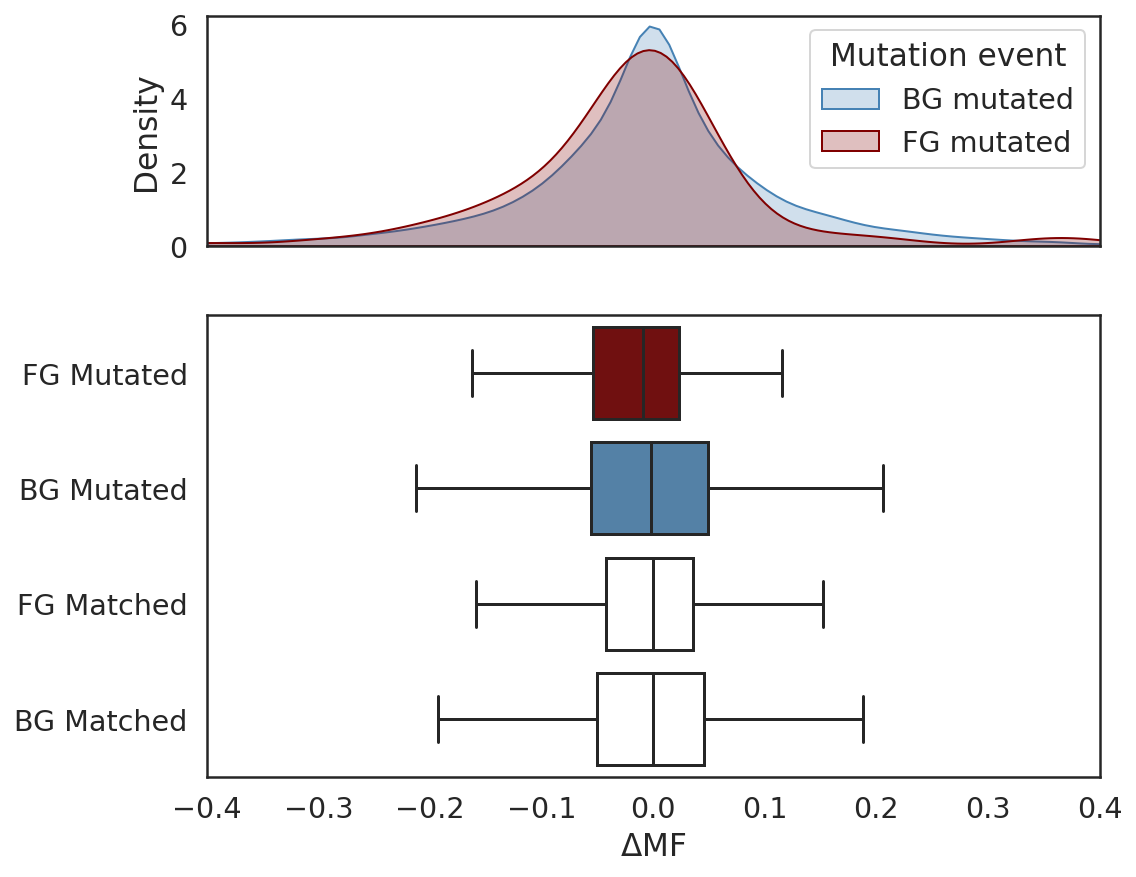

In [179]:
# make second axes taller
fig, axes = plt.subplots(2,1, figsize=(8, 7), sharex=True, gridspec_kw={'height_ratios': [1, 2]})
metric = 'mean_dmf'
mut = lit_all_mean_metrics_df.loc[lit_all_mean_metrics_df.mutated_sample == True]
mut = mut.rename(columns={'is_background': 'Mutation event'})#.replace({'Mutation event': {True: 'BG mutated samples', False: 'FG mutated samples'}})
# make FG mutated samples in front
sns.kdeplot(data=mut, x=metric, hue='Mutation event', common_norm=False, palette=[ 'maroon', 'steelblue'], fill=True, ax = axes[0])
# set xlim
axes[0].set_xlim(-.4, .4)
# write delta in geek sybol
axes[0].set_xlabel('Z-score of methylation change')
# change legend labels
axes[0].legend(['BG mutated', 'FG mutated'], loc='upper right', title='Mutation event')


# plot boxplots of mean_zdmf for each of the 4 groups: FG mutated, BG mutated, FG matched, BG matched
to_plot = lit_all_mean_metrics_df[[metric,'is_background', 'mutated_sample' ]].rename(columns={'is_background': 'FG/BG'}).replace({'FG/BG': {True: 'BG', False: 'FG'}})
to_plot = to_plot.rename(columns={'mutated_sample': 'Sample'}).replace({'Sample': {True: 'Mutated', False: 'Matched'}})
to_plot['combined'] = to_plot['FG/BG'] + ' ' + to_plot['Sample']

# create a pallette with the first as white, the second as steelblue, the third as white, and the fourth as maroon
pallette = [ 'maroon', 'steelblue', 'white','white']
sns.boxplot(data=to_plot, x=metric, y='combined', orient='h', ax = axes[1], showfliers=False, palette=pallette, order = ['FG Mutated', 'BG Mutated', 'FG Matched', 'BG Matched'])
# remove ylabel 
axes[1].tick_params(axis='y', labelrotation=0)
axes[1].set_ylabel('')
# delta in geek symbol
axes[1].set_xlabel(r'$\Delta$MF')

### Why are background sites so different?

#### hyper vs hypo
###### not all that differnet it turns out

In [73]:
# qnormed 
# read in comp sites from dask paruet
comparison_sites_dd = dd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/031423_comethyl_output/comparison_sites_0-1000Muts_db-linked_qnorm3SD_100background")
comparison_sites_df = comparison_sites_dd.compute()

all_metrics_dd = dd.read_parquet( "/cellar/users/zkoch/methylation_and_mutation/output_dirs/031423_comethyl_output/all_metrics_0-1000Muts_db-linked_qnorm3SD_100background")
all_metrics_df = all_metrics_dd.compute()

In [160]:
bg_methyls = []
bg_stdevs = []
fg_methyls = []
fg_stdevs = []
for i, row in comparison_sites_df.iterrows():
    # get mean methylation values of these sites in matched samples
    these_sites = all_methyl_age_df_t.loc[row['matched_samples'], row['comparison_sites']]
    mean_methyl = np.nanmean(these_sites, axis=0).tolist()
    stdev_methyl = np.nanstd(these_sites, axis=0).tolist()
    
    if row.is_background:
        bg_methyls += mean_methyl 
        bg_stdevs += stdev_methyl
    else:
        fg_methyls += mean_methyl
        fg_stdevs += stdev_methyl
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [162]:
sites_df = pd.DataFrame({'mean_methyl': bg_methyls + fg_methyls, 'stdev_methyl': bg_stdevs + fg_stdevs, 'is_background': [True] * len(bg_methyls) + [False] * len(fg_methyls)})

<AxesSubplot:xlabel='mean_methyl', ylabel='Probability'>

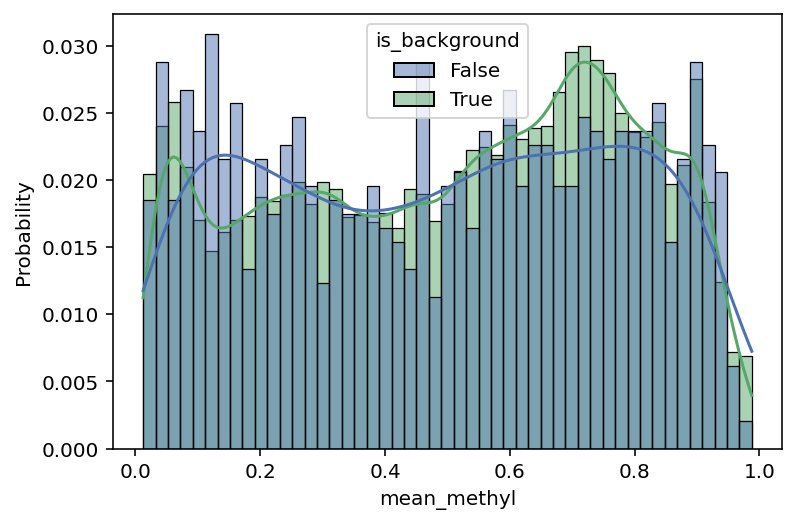

In [163]:
sns.histplot(data = sites_df, x = 'mean_methyl', hue = 'is_background', kde = True, stat = 'probability', common_norm=False, common_bins = True)

<AxesSubplot:xlabel='stdev_methyl', ylabel='Probability'>

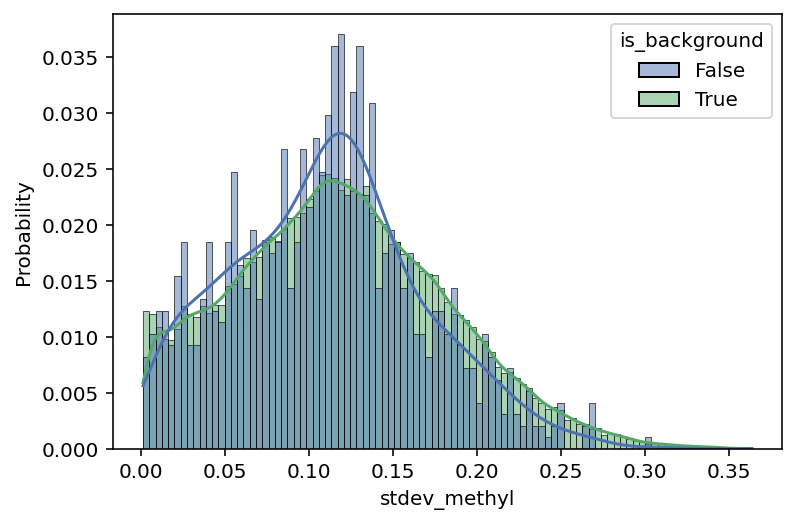

In [164]:
sns.histplot(data = sites_df, x = 'stdev_methyl', hue = 'is_background', kde = True, stat = 'probability', common_norm=False, common_bins = True)

## Distance of effect

### Distance

In [6]:
paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/distance_based_100kbMax/all_metrics*")
c_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/distance_based_100kbMax/comparison_sites*")

big_dist_all_metrics_dfs = []
for path in paths:
    # read in metrics sites from dask paruet
    one_metrics_dd = dd.read_parquet(path)
    one_metrics_df = one_metrics_dd.compute()
    big_dist_all_metrics_dfs.append(one_metrics_df)
big_dist_all_metrics_df = pd.concat(big_dist_all_metrics_dfs)
big_dist_all_metrics_df.reset_index(inplace=True, drop=True)


"""big_dist_all_comparison_site_dfs = []
for path in c_paths:
    # read in metrics sites from dask paruet
    one_comp_dd = dd.read_parquet(path)
    one_comp_df = one_comp_dd.compute()
    big_dist_all_comparison_site_dfs.append(one_comp_df)
big_dist_all_comparison_site_df = pd.concat(dist_all_comparison_site_dfs)
big_dist_all_comparison_site_df.reset_index(inplace=True, drop=True)"""

'big_dist_all_comparison_site_dfs = []\nfor path in c_paths:\n    # read in metrics sites from dask paruet\n    one_comp_dd = dd.read_parquet(path)\n    one_comp_df = one_comp_dd.compute()\n    big_dist_all_comparison_site_dfs.append(one_comp_df)\nbig_dist_all_comparison_site_df = pd.concat(dist_all_comparison_site_dfs)\nbig_dist_all_comparison_site_df.reset_index(inplace=True, drop=True)'

In [7]:
big_muts_events = big_dist_all_metrics_df['mut_event'].unique()
shared_real_muts = dist_all_mean_metrics_df.loc[
    (dist_all_mean_metrics_df['mutated_sample'])
    & (~dist_all_mean_metrics_df['is_background'])
    & (dist_all_mean_metrics_df['mut_event'].isin(big_muts_events))]
shared_real_muts.sort_values(by='mean_dmf', ascending=False, inplace=True)

/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [29]:
shared_real_muts

,mut_event,mean_dmf,mean_zdmf,mean_abs_dmf,mean_abs_zdmf,median_dmf,median_zdmf,median_abs_dmf,median_abs_zdmf,is_background,index_event,mutated_sample
26332890,TCGA-D9-A6EC_18:44336540,0.386183,2.255439,0.386183,2.255439,0.386183,2.255439,0.386183,2.255439,False,self,True
35542511,TCGA-EE-A29B_4:8621229,0.351942,1.194246,0.351942,1.194246,0.351942,1.194246,0.351942,1.194246,False,self,True
56638937,TCGA-R6-A8WC_5:134871157,0.342185,1.449724,0.342185,1.466319,0.325523,1.866621,0.325523,1.866621,False,self,True
14593964,TCGA-AX-A2HC_1:9099683,0.331305,1.616234,0.331305,1.616234,0.331305,1.616234,0.331305,1.616234,False,self,True
23647601,TCGA-D3-A8GI_17:9729473,0.310887,1.684054,0.310887,1.684054,0.265926,1.689641,0.265926,1.689641,False,self,True
...,...,...,...,...,...,...,...,...,...,...,...,...
15802561,TCGA-B5-A11E_6:29798656,-0.294053,1.373385,0.294053,1.373385,-0.294053,1.373385,0.294053,1.373385,False,self,True
51435150,TCGA-IH-A3EA_8:144940169,-0.298169,1.400068,0.298169,1.400068,-0.298169,1.400068,0.298169,1.400068,False,self,True
14649404,TCGA-AX-A2HC_2:241631297,-0.344513,3.051607,0.344513,3.051607,-0.345380,3.403122,0.345380,3.403122,False,self,True
3512867,TCGA-58-A46M_1:158259711,-0.388184,2.542349,0.388184,2.542349,-0.388184,2.542349,0.388184,2.542349,False,self,True


In [30]:
mut_event_to_plot = shared_real_muts['mut_event']
mut_event_to_plot_values = big_dist_all_metrics_df.loc[
    (big_dist_all_metrics_df['mut_event'].isin(mut_event_to_plot)) 
    | (big_dist_all_metrics_df['index_event'].isin(mut_event_to_plot)) 
    ]

In [31]:
min_dist = -int(100000 / 1000)
max_dist = int(100000 / 1000)
# bin int 10 bins 
mut_event_to_plot_values_subset = mut_event_to_plot_values.loc[
        (mut_event_to_plot_values['measured_site_dist'].abs() < 100000)
        & (mut_event_to_plot_values['mutated_sample'])
        ]
bin_num = 10
mut_event_to_plot_values_subset['dist_bin'] = pd.cut(mut_event_to_plot_values_subset['measured_site_dist'], bins = bin_num, 
                                                     labels = [ '[' + str(x) + ',' + str(x + int((max_dist - min_dist) / bin_num)) + ')' for x in range(min_dist, max_dist, int((max_dist - min_dist) / bin_num))])

/tmp/ipykernel_2318904/4150473894.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mut_event_to_plot_values_subset['dist_bin'] = pd.cut(mut_event_to_plot_values_subset['measured_site_dist'], bins = bin_num,


In [34]:
mut_event_to_plot_values_subset.rename(columns={'is_background': 'Mutation event'}, inplace=True)
mut_event_to_plot_values_subset['Mutation event'] = mut_event_to_plot_values_subset['Mutation event'].map({False: 'FG mutated', True: 'BG mutated'})


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/tmp/ipykernel_2318904/266597989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mut_event_to_plot_values_subset['Mutation event'] = mut_event_to_plot_values_subset['Mutation event'].map({False: 'FG mutated', True: 'BG mutated'})


Text(0, 0.5, '$\\Delta$MF')

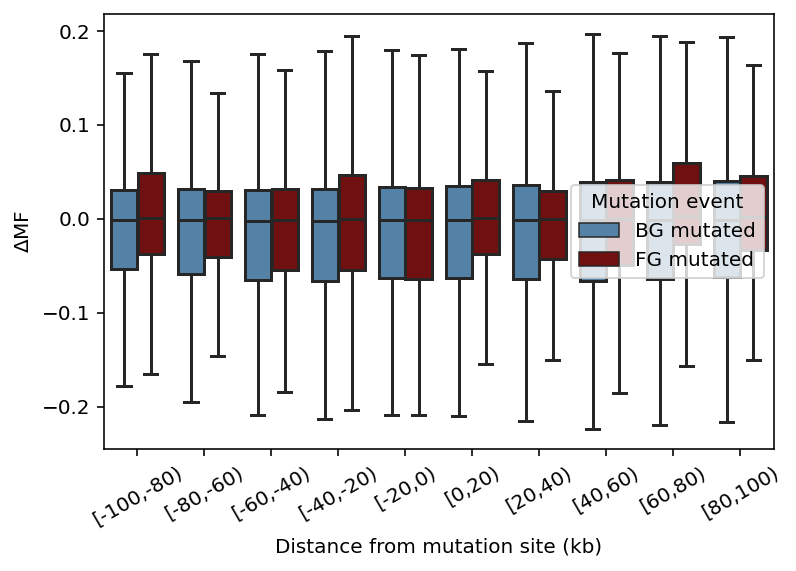

In [35]:
# all 200
sns.boxplot(
    data= mut_event_to_plot_values_subset,
    x = 'dist_bin', y = 'delta_mf_median', hue = 'Mutation event', showfliers = False,
    palette=['steelblue', 'maroon']
)
# angle x labels
plt.xticks(rotation=30)
plt.xlabel('Distance from mutation site (kb)')
plt.ylabel(r'$\Delta$MF')

Text(0, 0.5, '$\\Delta$MF')

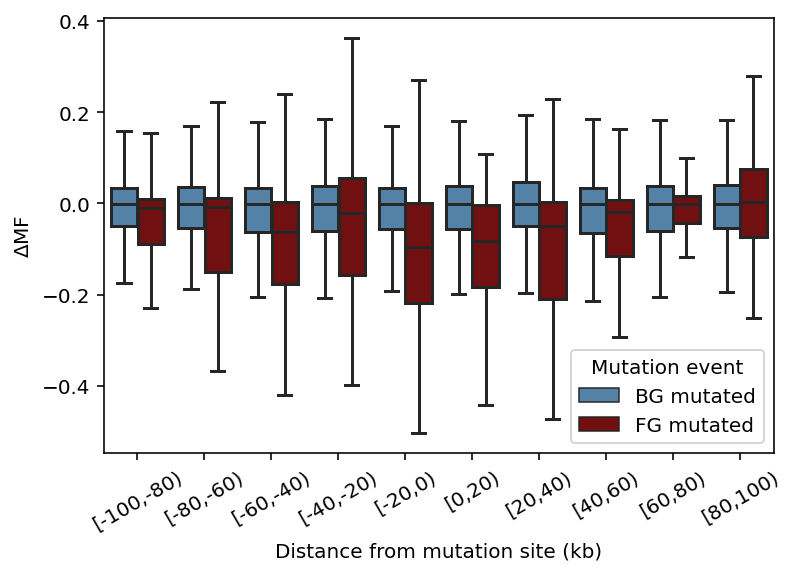

In [12]:
sns.boxplot(
    data= mut_event_to_plot_values_subset,
    x = 'dist_bin', y = 'delta_mf_median', hue = 'Mutation event', showfliers = False,
    palette=['steelblue', 'maroon']
)
# angle x labels
plt.xticks(rotation=30)
plt.xlabel('Distance from mutation site (kb)')
plt.ylabel(r'$\Delta$MF')

### Correlation

In [13]:
paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/correl_based_500Top/all_metrics*")
c_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/correl_based_500Top/comparison_sites*")

big_corr_all_metrics_dfs = []
for path in paths:
    # read in metrics sites from dask paruet
    one_metrics_dd = dd.read_parquet(path)
    one_metrics_df = one_metrics_dd.compute()
    big_corr_all_metrics_dfs.append(one_metrics_df)
big_corr_all_metrics_df = pd.concat(big_corr_all_metrics_dfs)
big_corr_all_metrics_df.reset_index(inplace=True, drop=True)


"""big_dist_all_comparison_site_dfs = []
for path in c_paths:
    # read in metrics sites from dask paruet
    one_comp_dd = dd.read_parquet(path)
    one_comp_df = one_comp_dd.compute()
    big_dist_all_comparison_site_dfs.append(one_comp_df)
big_dist_all_comparison_site_df = pd.concat(dist_all_comparison_site_dfs)
big_dist_all_comparison_site_df.reset_index(inplace=True, drop=True)"""

'big_dist_all_comparison_site_dfs = []\nfor path in c_paths:\n    # read in metrics sites from dask paruet\n    one_comp_dd = dd.read_parquet(path)\n    one_comp_df = one_comp_dd.compute()\n    big_dist_all_comparison_site_dfs.append(one_comp_df)\nbig_dist_all_comparison_site_df = pd.concat(dist_all_comparison_site_dfs)\nbig_dist_all_comparison_site_df.reset_index(inplace=True, drop=True)'

In [15]:
all_mean_metrics_df.reset_index(inplace=True)

In [17]:
# find the mut events shared by mean metrics and big run
big_muts_events_corr = big_corr_all_metrics_df['mut_event'].unique()
shared_real_muts_corr = all_mean_metrics_df.loc[
    (all_mean_metrics_df['mutated_sample']) 
    & (~all_mean_metrics_df['is_background']) 
    & (all_mean_metrics_df['mut_event'].isin(big_muts_events_corr))
    ]
shared_real_muts_corr.sort_values(by='mean_dmf', ascending=False, inplace=True)

/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [18]:
# choose with most negative mean dmf 
neg_mut_event_to_plot_corr = shared_real_muts_corr.tail(20)['mut_event']
neg_mut_event_to_plot_values_corr = big_corr_all_metrics_df.loc[
    (big_corr_all_metrics_df['mut_event'].isin(neg_mut_event_to_plot_corr)) 
    | (big_corr_all_metrics_df['index_event'].isin(neg_mut_event_to_plot_corr)) 
    ]
neg_mut_event_to_plot_values_corr.rename(columns={'is_background': 'Mutation event'}, inplace=True)
neg_mut_event_to_plot_values_corr['Mutation event'] = neg_mut_event_to_plot_values_corr['Mutation event'].map({False: 'FG mutated', True: 'BG mutated'})


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/tmp/ipykernel_2318904/1328601103.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_mut_event_to_plot_values_corr['Mutation event'] = neg_mut_event_to_plot_values_corr['Mutation event'].map({False: 'FG mutated', True: 'BG mutated'})


In [25]:
min_dist = 0
max_dist = 500
# bin int 10 bins 
neg_mut_event_to_plot_values_corr_subset = neg_mut_event_to_plot_values_corr.loc[
        (neg_mut_event_to_plot_values_corr['measured_site_dist'].abs() < 501)
        & (neg_mut_event_to_plot_values_corr['mutated_sample'])
        ]
bin_num = 10
neg_mut_event_to_plot_values_corr_subset['dist_bin'] = pd.cut(neg_mut_event_to_plot_values_corr_subset['measured_site_dist'], bins = bin_num, 
                                                     labels = [ '[' + str(x) + ',' + str(x + int((max_dist - min_dist) / bin_num)) + ')' for x in range(min_dist, max_dist, int((max_dist - min_dist) / bin_num))])

/tmp/ipykernel_2318904/2463511610.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_mut_event_to_plot_values_corr_subset['dist_bin'] = pd.cut(neg_mut_event_to_plot_values_corr_subset['measured_site_dist'], bins = bin_num,


Text(0, 0.5, '$\\Delta$MF')

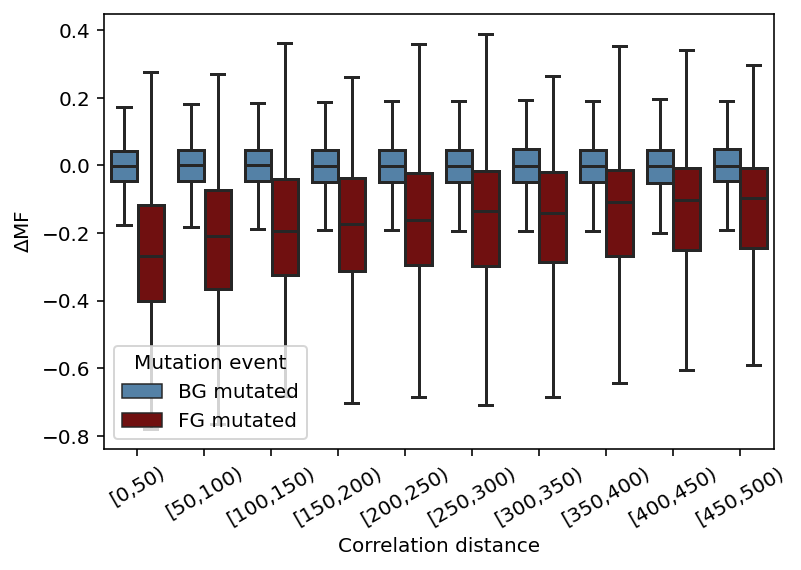

In [26]:
sns.boxplot(
    data= neg_mut_event_to_plot_values_corr_subset.loc[(neg_mut_event_to_plot_values_corr_subset['mutated_sample'])], x = 'dist_bin', y = 'delta_mf_median', hue = 'Mutation event', showfliers = False, palette=['steelblue', 'maroon']
)
# angle x labels
plt.xticks(rotation=30)
plt.xlabel('Correlation distance')
plt.ylabel(r'$\Delta$MF')